# Adaptive Filters Tutorial

The following tutorial will compare least mena square,
recurse least squares and kernel adaptive filters. 

We will compare the algorithms on performance on the task of system identification as well as time series prediction

# Preparation

## import libraries

we will use the standard libraries for scientific computing in python,
namely numeric python (numpy), scientific python and plotting tool

In [1]:
import numpy as np
from scipy.linalg import toeplitz
import scipy.io as sio
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# adjust size of plots
plt.rcParams['figure.figsize'] = (20.0, 8.0)

## Implementation of least mean squares algorithm

A linear time invariant FIR filter can completely be describe by its 
impulse response. The operation of filtering an input signal, also called
convolution can be expressed as the dot product of an input vector (x) of
corresponding size with the impulse response (w).


Based on Moschytz, G., & Hofbauer, M. (2000). 
Adaptive Filter. Berlin ua: Springer. p.121

In [3]:
class LMS:
    '''create least mean square adaptive filter'''
    def __init__(self,num_params = 5,stepsize = 0.01):
        self.num_params = num_params
        self.stepsize = stepsize
        self.weights = [np.zeros(num_params)]
        self.errors = []
        self.estimate = []
        
    def predict(self,x):
        '''apply filter to given input'''
        estimate = x @ self.weights[-1]
        return estimate

    def update(self,x,d):
        '''update the filter wights to minimize estimation error'''
        e = d - self.predict(x)
        new_w = self.weights[-1] + self.stepsize * e * x
        self.errors.append(e**2)
        self.weights.append(new_w)
    
    def learn(self,in_vec,desired_vec):
        '''learn filter wights for a given data set'''
        in_mat = toeplitz(in_vec)[:self.num_params,:]
        for i in range(0,len(desired_vec)):
            self.update(in_mat[:,i],desired_vec[i])

In [4]:
hoho = LMS(5,0.01)

## Implementation of recursive least squares algorithm

Based on Moschytz, G., & Hofbauer, M. (2000). Adaptive Filter. Berlin ua: Springer. p.145

In [5]:
class RLS:
    '''create a recursive least squares filter'''
    def __init__(self,num_params = 5, rate = 1):
        self.num_params = num_params
        self.weights = [np.zeros(num_params)]
        self.Rinv = 1000000 * np.eye(num_params,num_params)
        self.rate = rate
        self.error = []
        self.estaimtes = []
        
    def predict(self,x):
        '''prediction of given data point x'''
        estimate = x @ self.weights[-1]
        return estimate
    
    def update(self,x,d):
        '''perform a recursive least squares weight update'''
        # obtain error as difference to d
        e = d - self.predict(x)
        # filtered normalized data vector
        z = self.Rinv@x / (1 + x@self.Rinv@x)
        # update w by adding scaled version of z
        w_new = self.weights[-1] + e * z.T
        # update Rinv
        self.Rinv = (1/self.rate) * (self.Rinv - np.outer(z,x) @ self.Rinv)
        self.error.append(e)
        self.weights.append(w_new)

    def learn(self,in_vec,desired_vec):
        '''performs the recursive least squares algorithm on every samples'''
        in_mat = toeplitz(in_vec)[:self.num_params,:]
        for i in range(0,len(desired_vec)):
            self.update(in_mat[:,i],desired_vec[i])

## helper functions for plotting

In [6]:
def rms(X):
    '''
    standart root mean square, 
    expects X to be a row vector
    '''
    return 1/X.shape[0]*np.sum(np.square(X))

def addnoise(X,var):
    '''
    adds noise of variance 'var' to input vector X
    it will help simulate measurement noise
    '''
    length = X.shape
    std = np.sqrt(var)
    XN = X + np.random.normal(0,std,length)
    return XN

def smooth(X,N=200):
    '''
    smoothing vector X 
    by moving average of N=200 values
    '''
    window = np.ones((N,))/N
    return np.convolve(X,window,mode='valid')

def plot(values,label='',stop=-1, linewidth=0.5):
    '''
    automatically applies smoothing
    and sets defaults for linewidth and legends
    '''
    plt.xlabel('setp of iteration'); plt.ylabel('squared prediction error')
    plt.plot(smooth(values[:stop]),linewidth=linewidth,label=label);
    plt.legend(); 

# FIR system identification

## load given data

In [7]:
# load provided data
FIR = sio.loadmat('AF2018/System_FIR3.mat')
IIR = sio.loadmat('AF2018/System_IIR3.mat')
FIRx = sio.loadmat('AF2018/Systemwechsel_FIR3.mat')
IIRx = sio.loadmat('AF2018/Systemwechsel_IIR3.mat')
# input signal
Xfir = FIR['X'][0].astype('float64')
Xiir = IIR['X'][0].astype('float64')
Xfirx = FIRx['X'][0].astype('float64')
Xiirx = IIRx['X'][0].astype('float64')
# desired signal
Dfir = FIR['D_'][0][0:10000].astype('float64')
Diir = IIR['D_'][0][0:10000].astype('float64')
Dfirx = FIRx['D_'][0][0:10000].astype('float64')
Diirx = IIRx['D_'][0][0:10000].astype('float64')

## given FIR filter

in this chapter the implemented algorithms are evaluated and compared at performing a system identification 
of the following FIR Filter:

![Struktur des Filters](AF2018/FIRstructure.png)

![Gewichte des Filters](AF2018/FIRweights.png)

## validate desire function to given coefficients

let us first check, if we can replicate the desired signal from the input signal filterd with the presented FIR filter.
We therefore create our own filter using the coefficients h0 to h4 and let it run on the input signal Xfir.
By comparing the result Hfir with the desired Signal Dfir we can confirm the testing setup.

In [8]:
import scipy.signal as sig
# FIR systems coefficients:
Hfir = np.array([0.7, 0.1, -0.03, 0.18, -0.24])
# create filter with given taps
Dfir_hat = sig.lfilter(tuple(Hfir),tuple([1,0]),tuple(Xfir))
# compare provided output to manual computation:
'Identical signals?', np.allclose(Dfir_hat,Dfir)

('Identical signals?', True)

In the derivation of LMS the input signal was assumed to be mean free.
Let us check if this the case for the given input.

In [9]:
# validate mean free input, check variance
np.mean(Xfir), np.var(Xfir)

(-0.004502597590200214, 1.011331682341236)

that is, we have a nearly mean free signal $\overline{x}$ with a $\sigma\approx1$

## comparison of number of tabs while low noise

An adaptive filter which has less degrees of freedom (filter taps) than the system it is supposed to model will fail to match as it can not reproduce the variance that lived in the missing dimensions. Therefore we expect a significantly worse fit of our model resulting in a poor error in the region of convergence. The system with only few coefficients will adapt itslef within the boundary of it's possibility, so there will be a learning curve that descends at first. However when coming to the region of convergence it will wiggle quite strongly and have an offset according to the missed variance.
Choosing a higher model complexity (many filter taps) for our adaptive filter than would be necessary for the system we are trying to identify is not expected to further reduce the error. This is because the additional degrees of freedom have no variance left and lack the data to develop a valuable mapping. The system is underdetermined and does not have a single optima in the weight space. The error surface is not a paraboloid anymore but at least includes saddle points in the unnecessary dimensions.

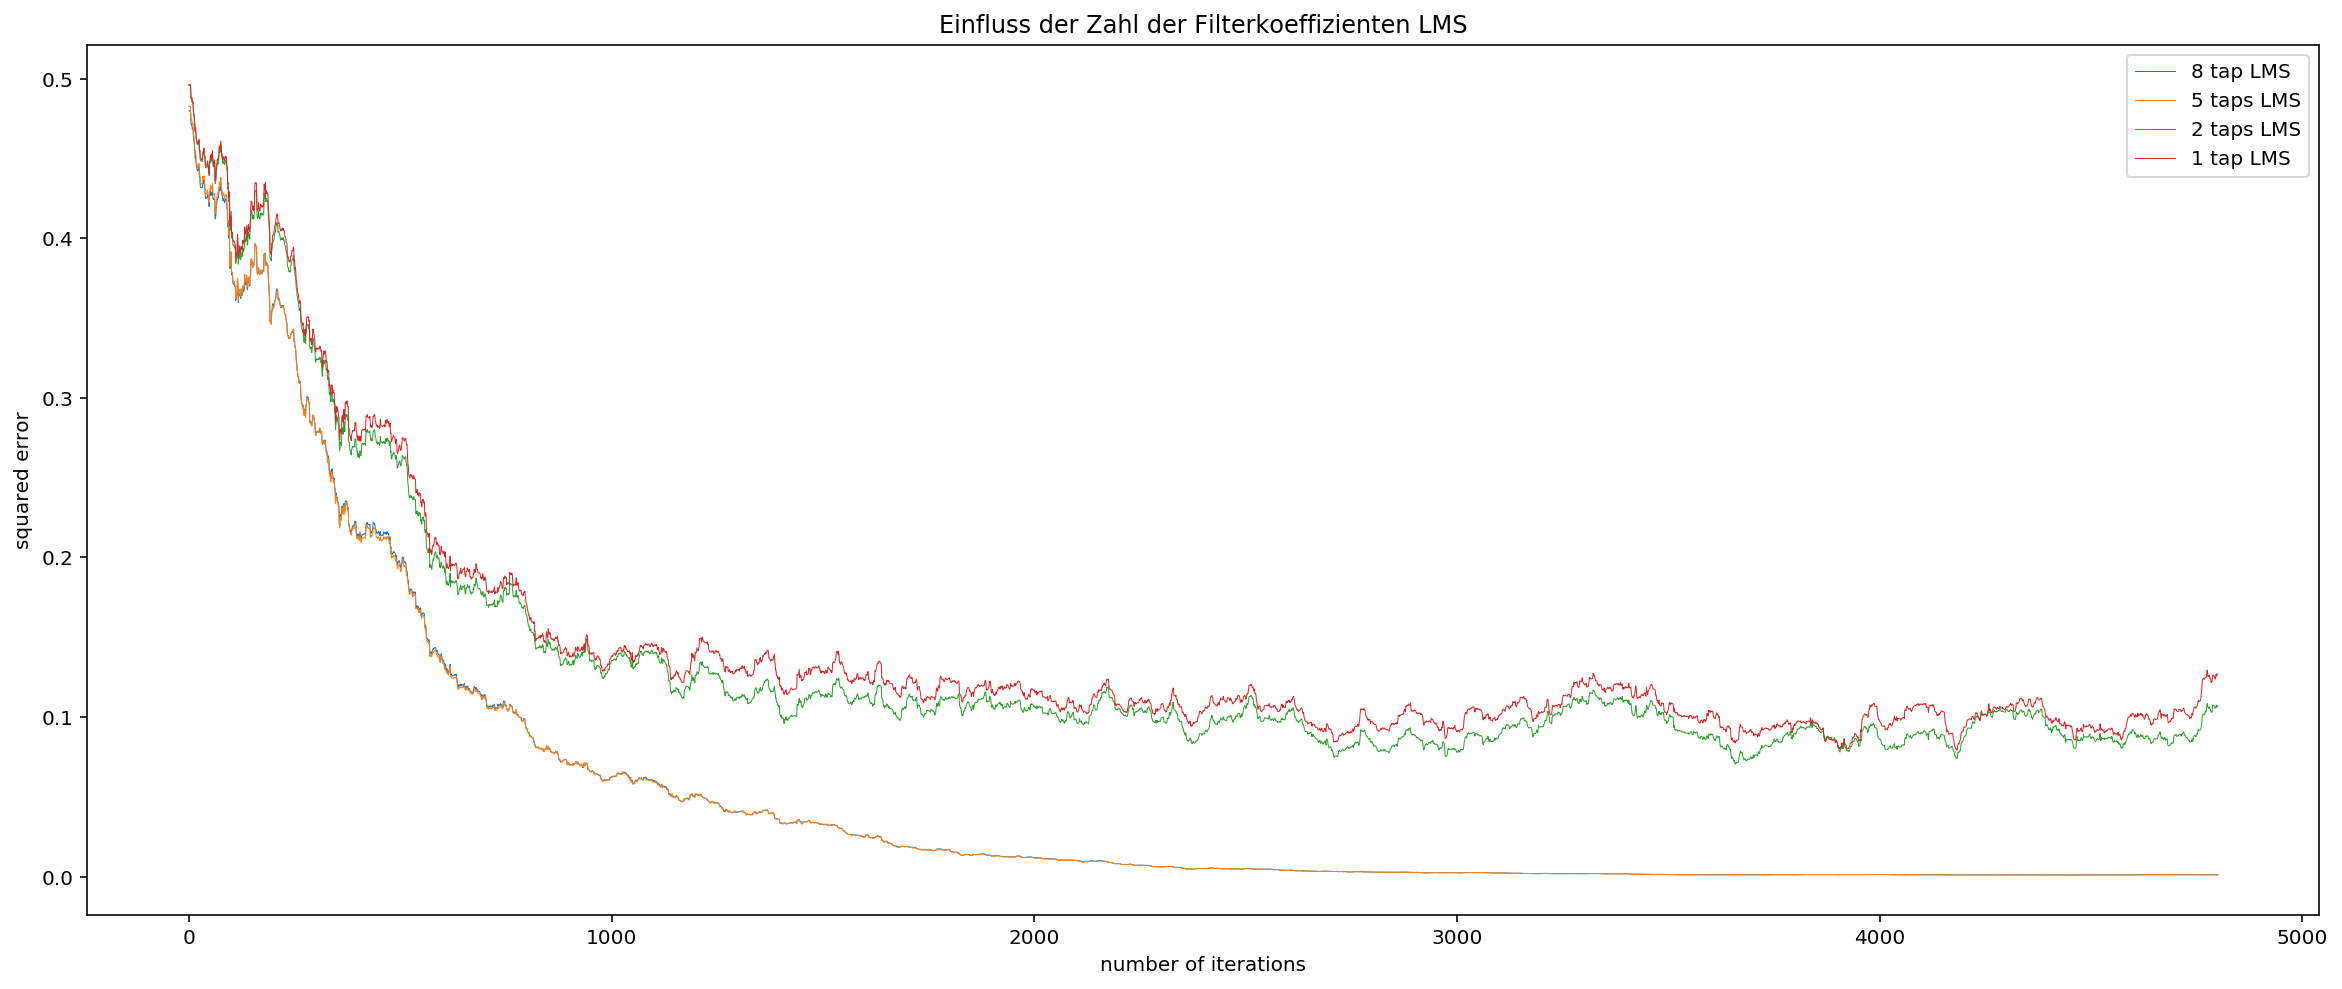

In [10]:
DfirN0001 = addnoise(Dfir,0.001)

plot(lms(8,DfirN0001,Xfir,0.001)[1],'8 tap LMS',5000)
plot(lms(5,DfirN0001,Xfir,0.001)[1],'5 taps LMS',5000)
plot(lms(2,DfirN0001,Xfir,0.001)[1],'2 taps LMS',5000)
plot(lms(1,DfirN0001,Xfir,0.001)[1],'1 tap LMS',5000)
plt.legend(); plt.title('Einfluss der Zahl der Filterkoeffizienten LMS');
plt.ylabel('squared error'); plt.xlabel('number of iterations');

In [10]:
lms1, lms2, lms5, lms8 = LMS(1), LMS(2), LMS(5), LMS(8)
lms1.learn(Xfir,DfirN0001,0.001)


NameError: name 'DfirN0001' is not defined

In [ ]:

DfirN0001 = addnoise(Dfir,0.001)

plot(lms(8,DfirN0001,Xfir,0.001)[1],'8 tap LMS',5000)
plot(lms(5,DfirN0001,Xfir,0.001)[1],'5 taps LMS',5000)
plot(lms(2,DfirN0001,Xfir,0.001)[1],'2 taps LMS',5000)
plot(lms(1,DfirN0001,Xfir,0.001)[1],'1 tap LMS',5000)
plt.legend(); plt.title('Einfluss der Zahl der Filterkoeffizienten LMS');
plt.ylabel('squared error'); plt.xlabel('number of iterations');

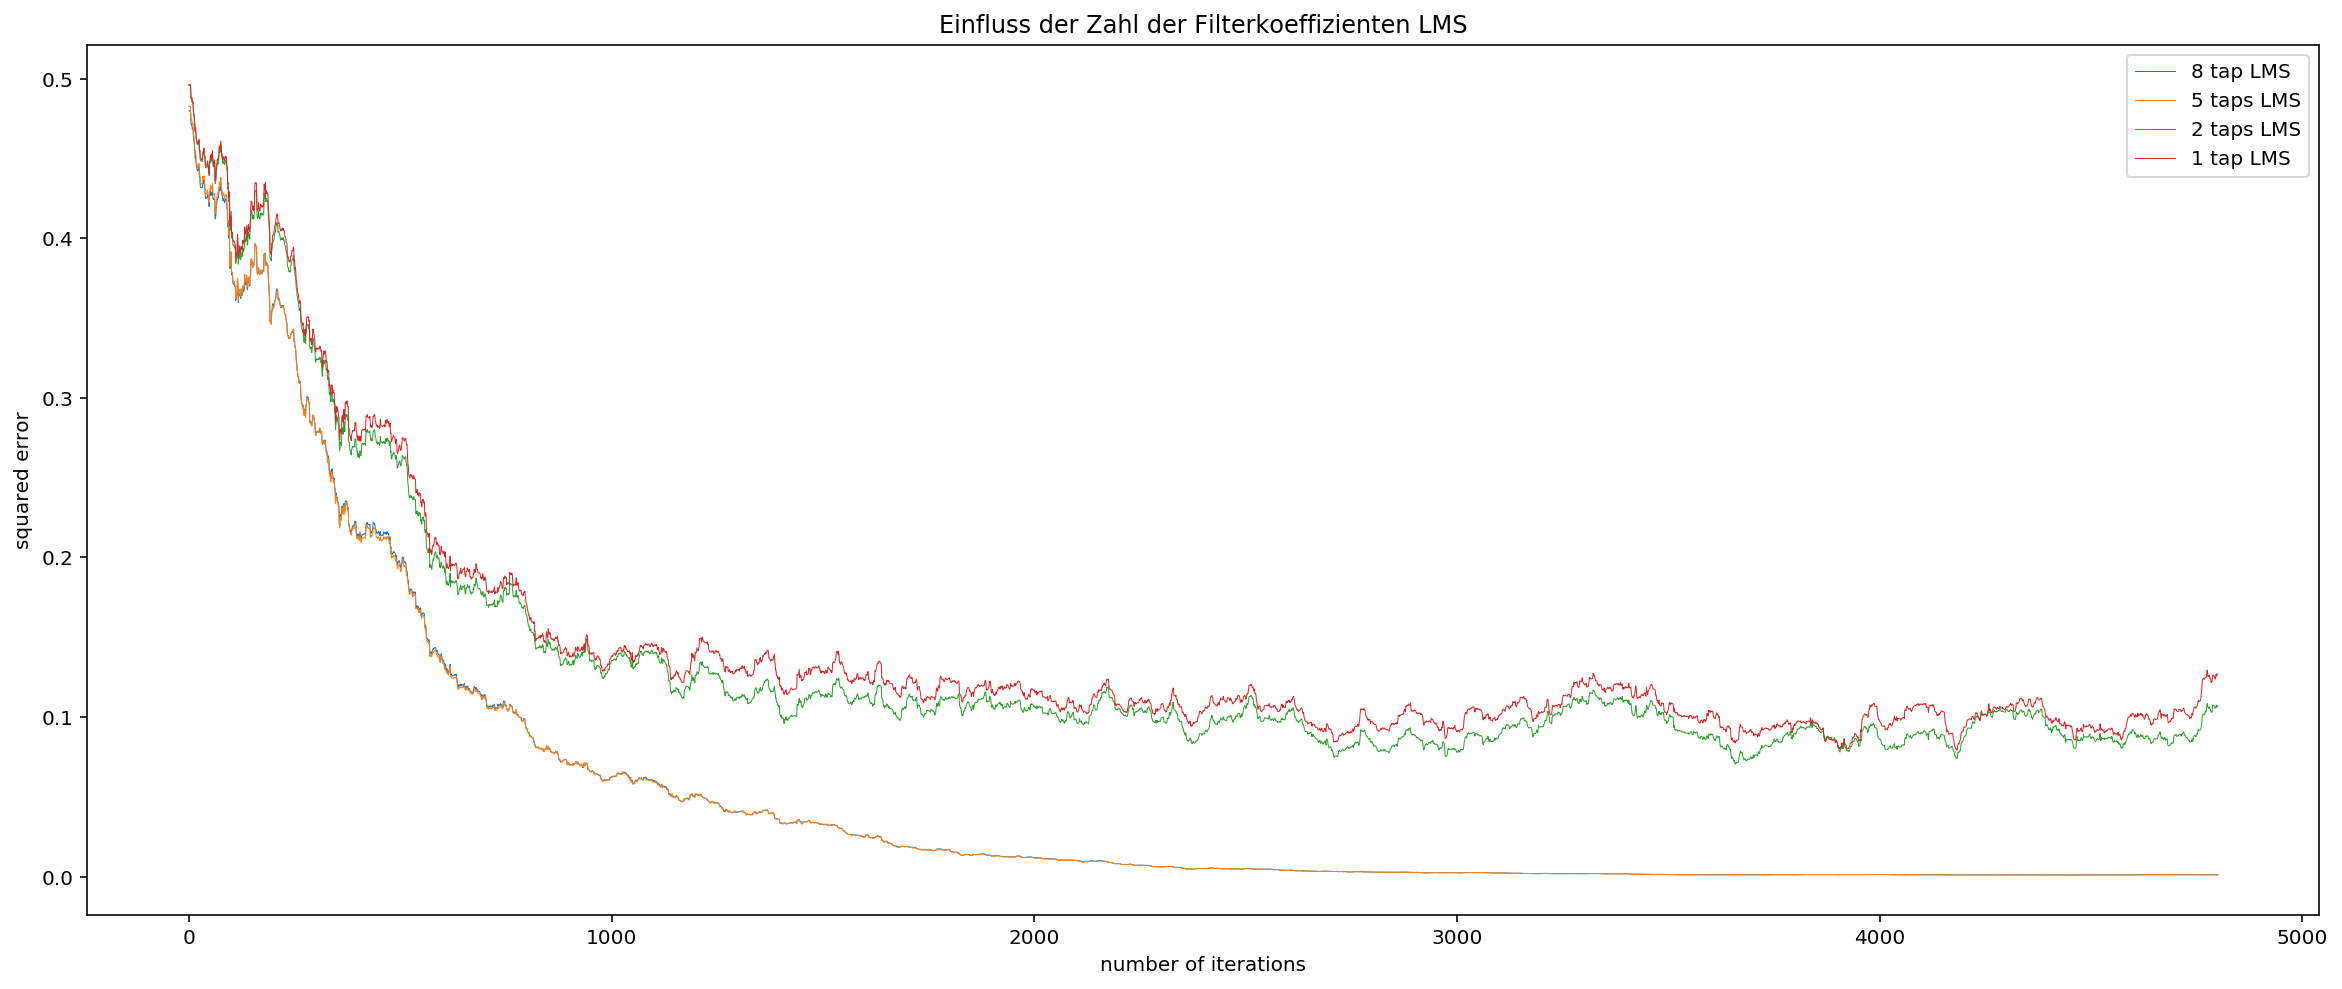

In [10]:
DfirN0001 = addnoise(Dfir,0.001)

plot(lms(8,DfirN0001,Xfir,0.001)[1],'8 tap LMS',5000)
plot(lms(5,DfirN0001,Xfir,0.001)[1],'5 taps LMS',5000)
plot(lms(2,DfirN0001,Xfir,0.001)[1],'2 taps LMS',5000)
plot(lms(1,DfirN0001,Xfir,0.001)[1],'1 tap LMS',5000)
plt.legend(); plt.title('Einfluss der Zahl der Filterkoeffizienten LMS');
plt.ylabel('squared error'); plt.xlabel('number of iterations');

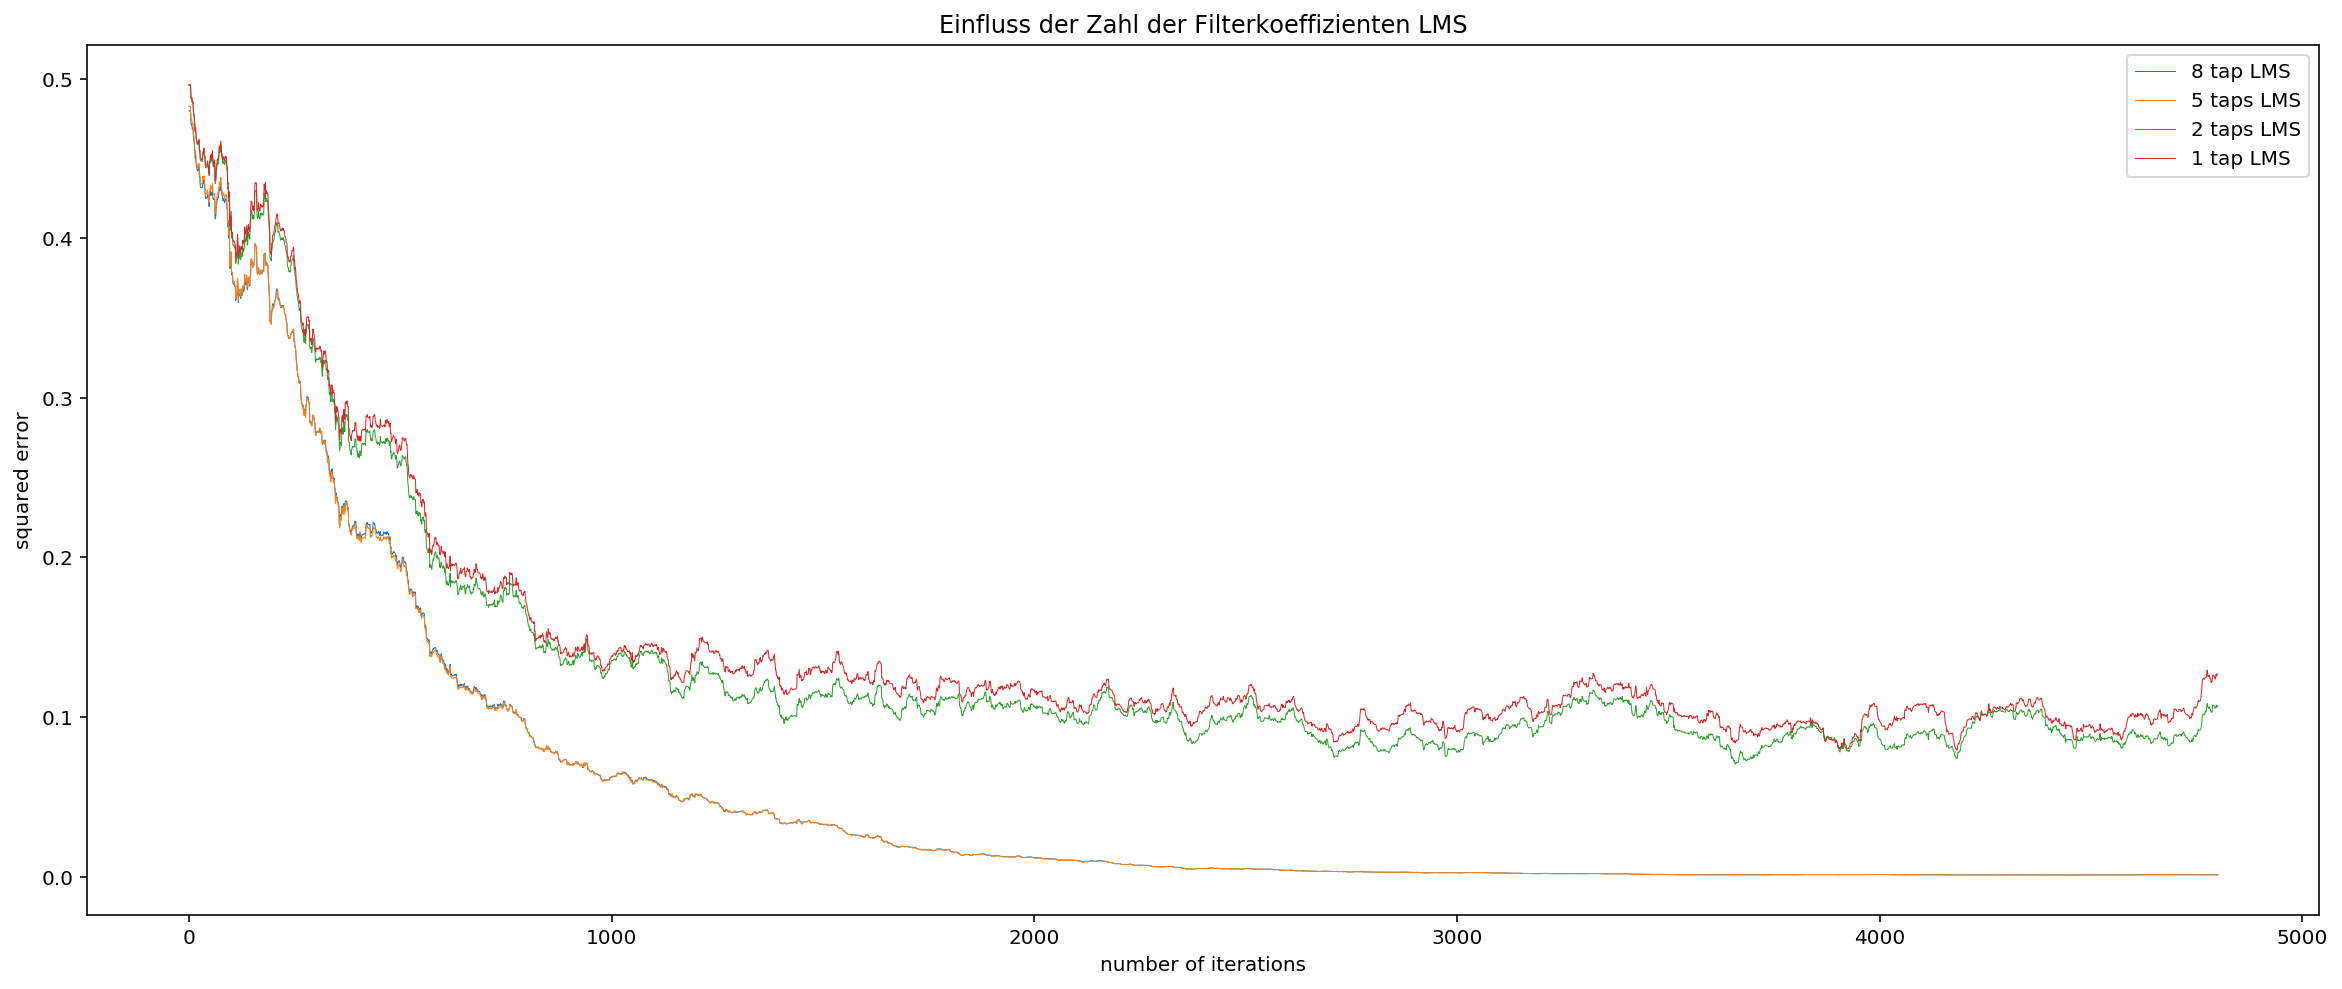

In [10]:
DfirN0001 = addnoise(Dfir,0.001)

plot(lms(8,DfirN0001,Xfir,0.001)[1],'8 tap LMS',5000)
plot(lms(5,DfirN0001,Xfir,0.001)[1],'5 taps LMS',5000)
plot(lms(2,DfirN0001,Xfir,0.001)[1],'2 taps LMS',5000)
plot(lms(1,DfirN0001,Xfir,0.001)[1],'1 tap LMS',5000)
plt.legend(); plt.title('Einfluss der Zahl der Filterkoeffizienten LMS');
plt.ylabel('squared error'); plt.xlabel('number of iterations');

In [11]:
DfirN0001 = addnoise(Dfir,0.001)
print('convergence successful?')
np.all(np.round(lms(5,DfirN0001,Xfir,0.001)[0][:,-1],2)==Hfir)

convergence successful?


NameError: name 'lms' is not defined

The additional simulated measurement noise power was kept to a minimum as for not to blure this effects unnecessarily. 
Additionally we chose a relatively small learning rate $\mu$ so that the convergence can be observed more clearly.

The simulation shows that indeed the filters of less taps (green and red) retain a higher error and keep on wiggeling strongly in the region of convergence. The filter with matching taps (orange) is capable of reducing the error perfeclty. We can see, that it correctly identifies the systems coefficients. The filter of additional taps (blue) does also converge nicely but does not converge any faster than the one with matching number of taps.

The same considerations apply to the RLS algorithm.

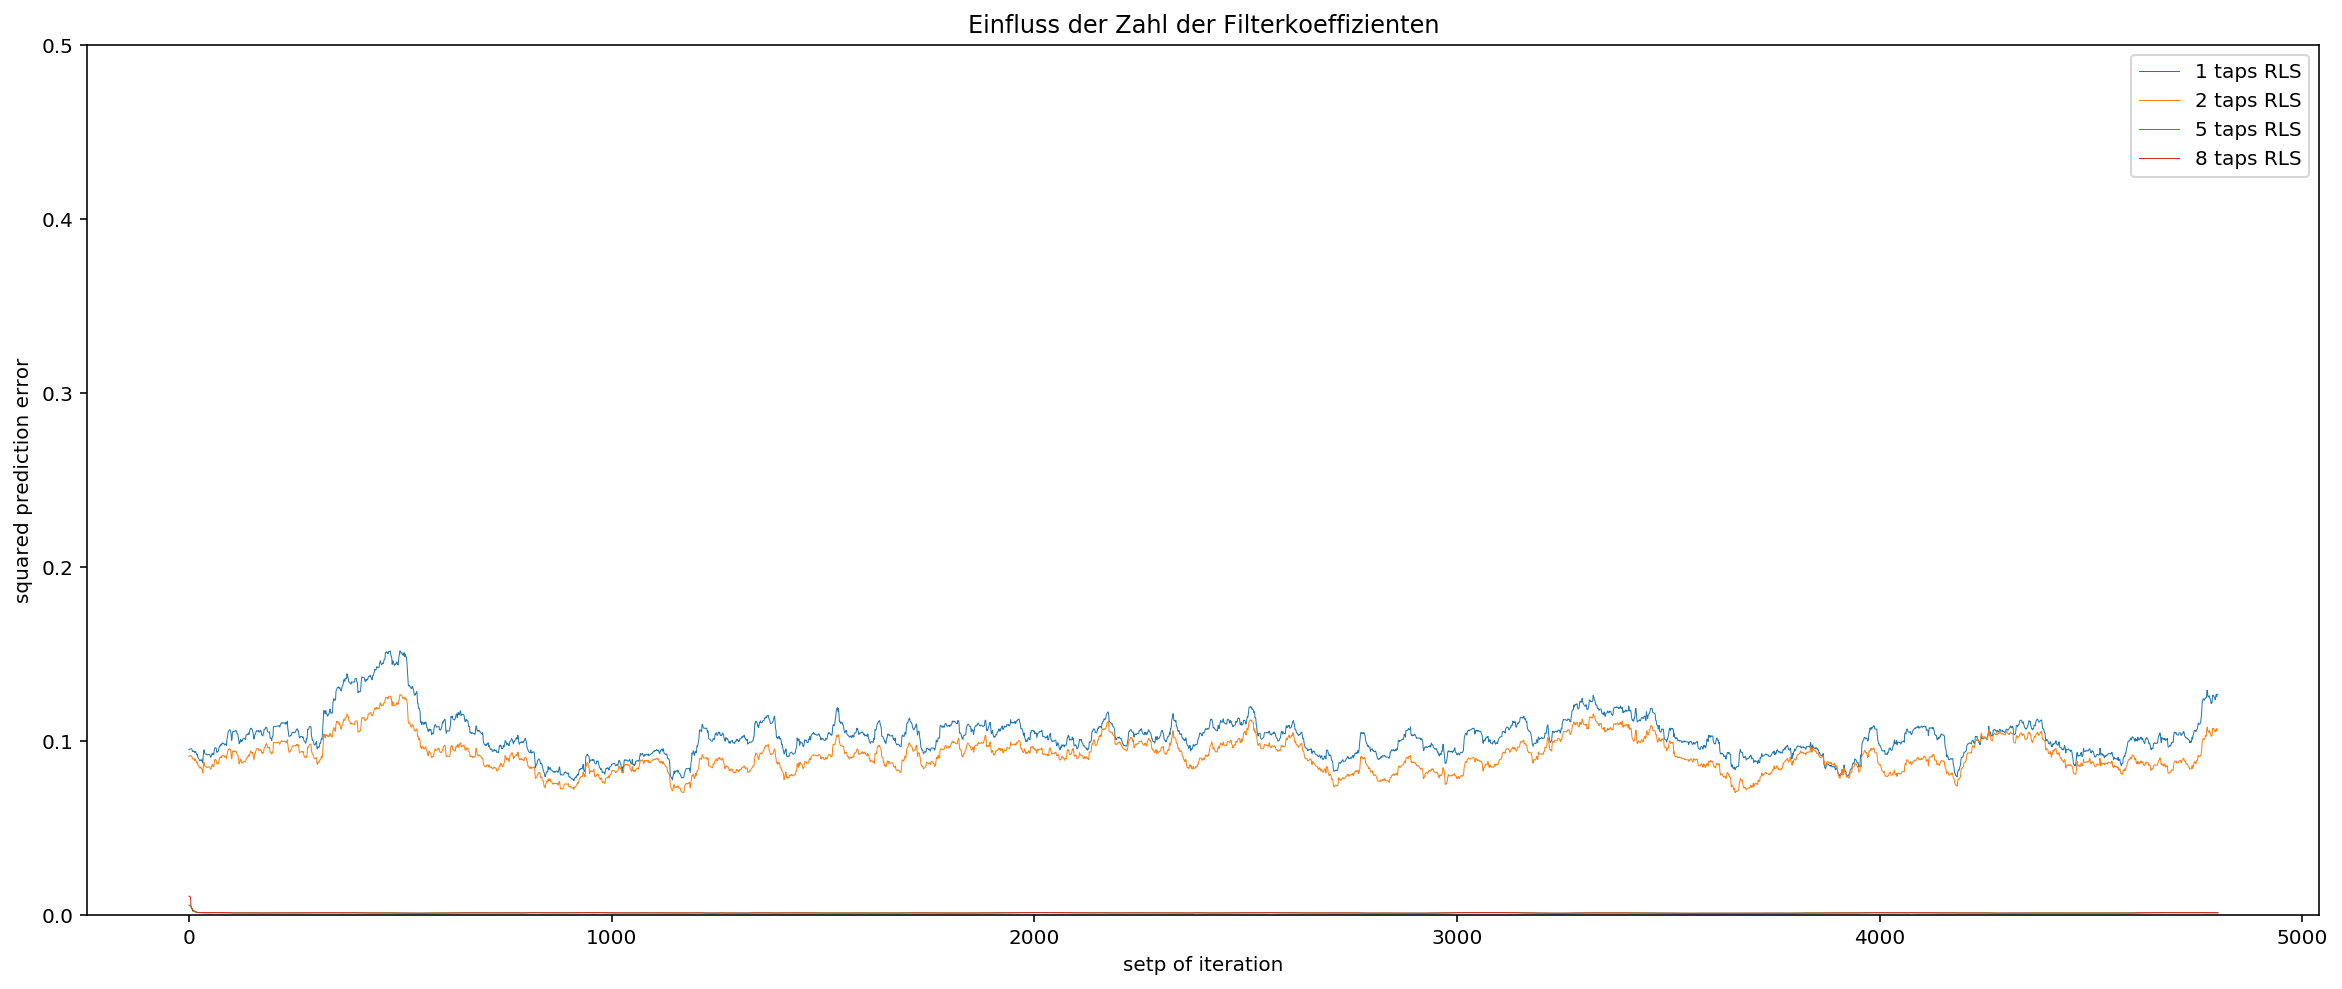

In [12]:
[plot(rls(taps,DfirN0001,Xfir)[1],str(taps)+' taps RLS',5000) for taps in [1,2,5,8]]
plt.legend(); plt.title('Einfluss der Zahl der Filterkoeffizienten');
plt.ylim(0,0.5);

In [12]:
print('convergence successful?')
np.all(np.round(rls(5,DfirN0001,Xfir)[0][:,-1],2)==Hfir)

convergence successful?


NameError: name 'rls' is not defined

When creating a filter with 20 taps it can be shown that all the unnecessary taps converge to 0.

NameError: name 'lms' is not defined

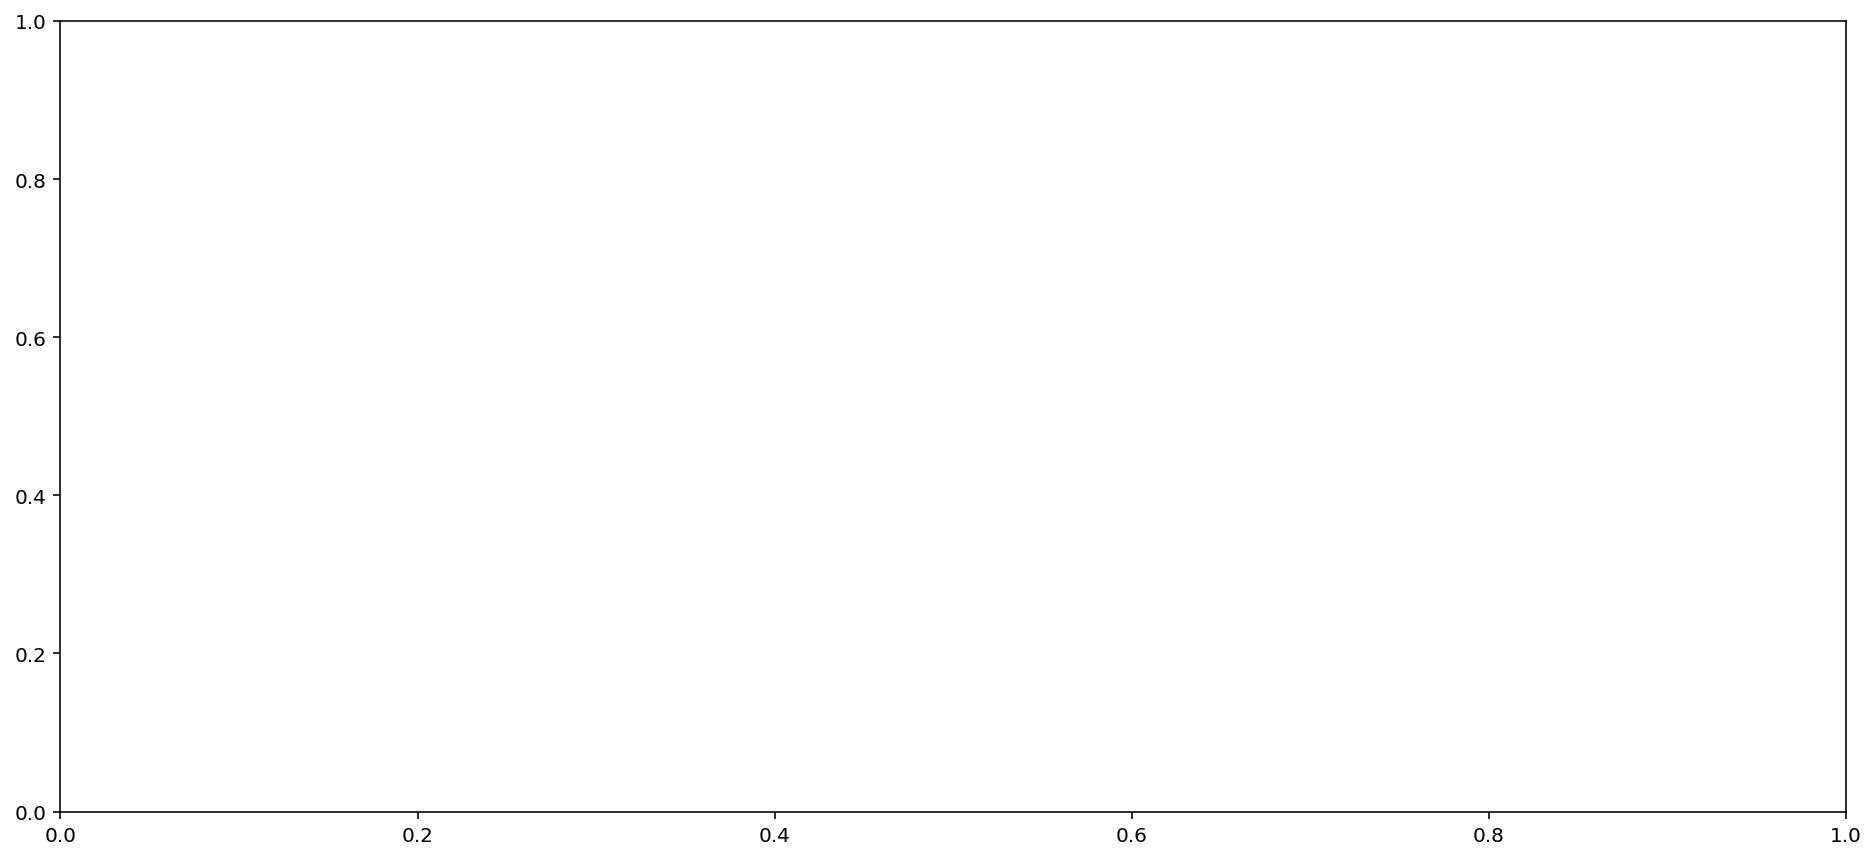

In [13]:
plt.figure(figsize=(16,16))
plt.subplot(211)
#plt.plot(np.apply_along_axis(smooth,1,lms(5,Dfir,Xfir)[0]).T[:500]);
plt.plot(lms(5,Dfir,Xfir)[0].T[:500],linewidth=0.4);
plt.title('history of the values that the 5 coefficients take over 500 iterations');
plt.ylabel('value of coefficient')
plt.subplot(212);
#plt.plot(np.apply_along_axis(smooth,1,lms(20,Dfir,Xfir)[0]).T[:500]);
plt.plot(lms(20,Dfir,Xfir)[0].T[:500],linewidth=0.4);
plt.title('history of the values that the 20 coefficients take over 500 iterations');
plt.ylabel('value of coefficient');

## robustnest to noise at fixed number of taps

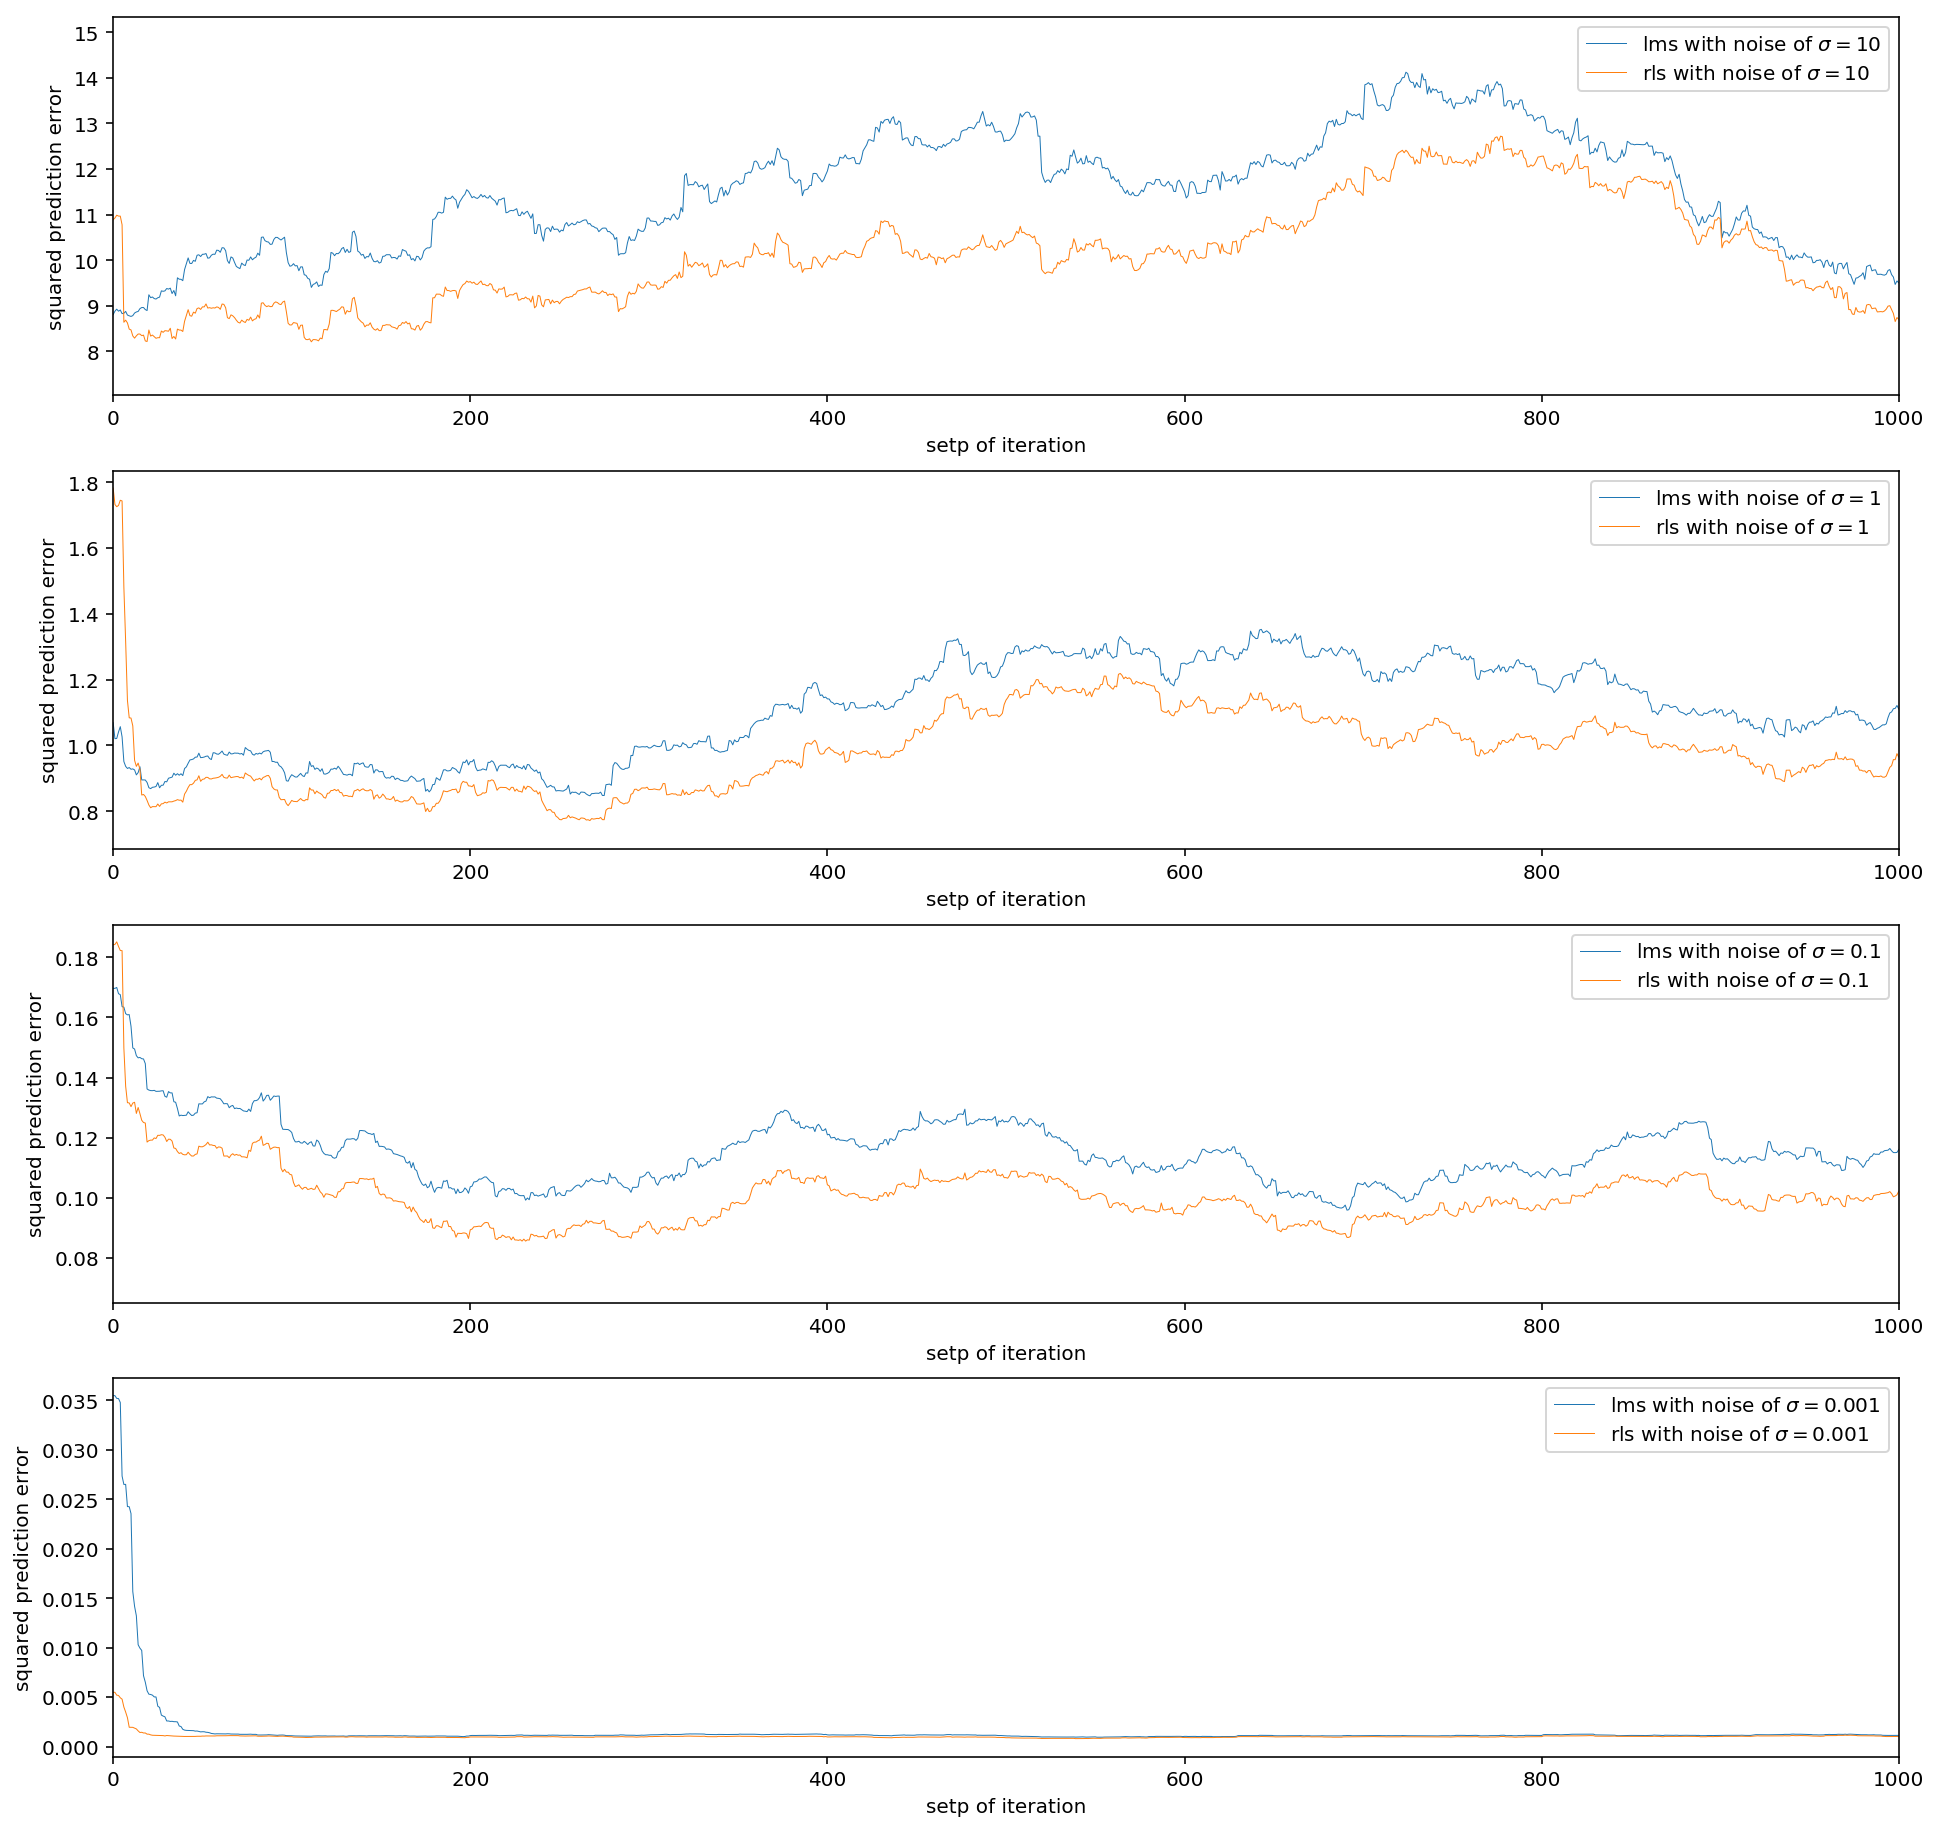

In [15]:
DfirN10 = addnoise(Dfir,10)
DfirN1 = addnoise(Dfir,1)
DfirN01 = addnoise(Dfir,0.1)

pltmax = 1000
mu = 0.05

plt.figure(figsize=(16,16))
plt.subplot(411); plt.xlim(0,pltmax)
plot(lms(5,DfirN10,Xfir,mu)[1],'lms with noise of $\sigma=10$')
plot(rls(5,DfirN10,Xfir)[1],'rls with noise of $\sigma=10$')
plt.subplot(412); plt.xlim(0,pltmax)
plot(lms(5,DfirN1,Xfir,mu)[1],'lms with noise of $\sigma=1$')
plot(rls(5,DfirN1,Xfir)[1],'rls with noise of $\sigma=1$')
plt.subplot(413); plt.xlim(0,pltmax)
plot(lms(5,DfirN01,Xfir,mu)[1],'lms with noise of $\sigma=0.1$')
plot(rls(5,DfirN01,Xfir)[1],'rls with noise of $\sigma=0.1$')
plt.subplot(414); plt.xlim(0,pltmax)
plot(lms(5,DfirN0001,Xfir,mu)[1],'lms with noise of $\sigma=0.001$')
plot(rls(5,DfirN0001,Xfir)[1],'rls with noise of $\sigma=0.001$')
#plt.tight_layout()

rls is much robuster to noise and we increasing learning speed lms gets more sensitive to noise

## effect of learning rate in lms

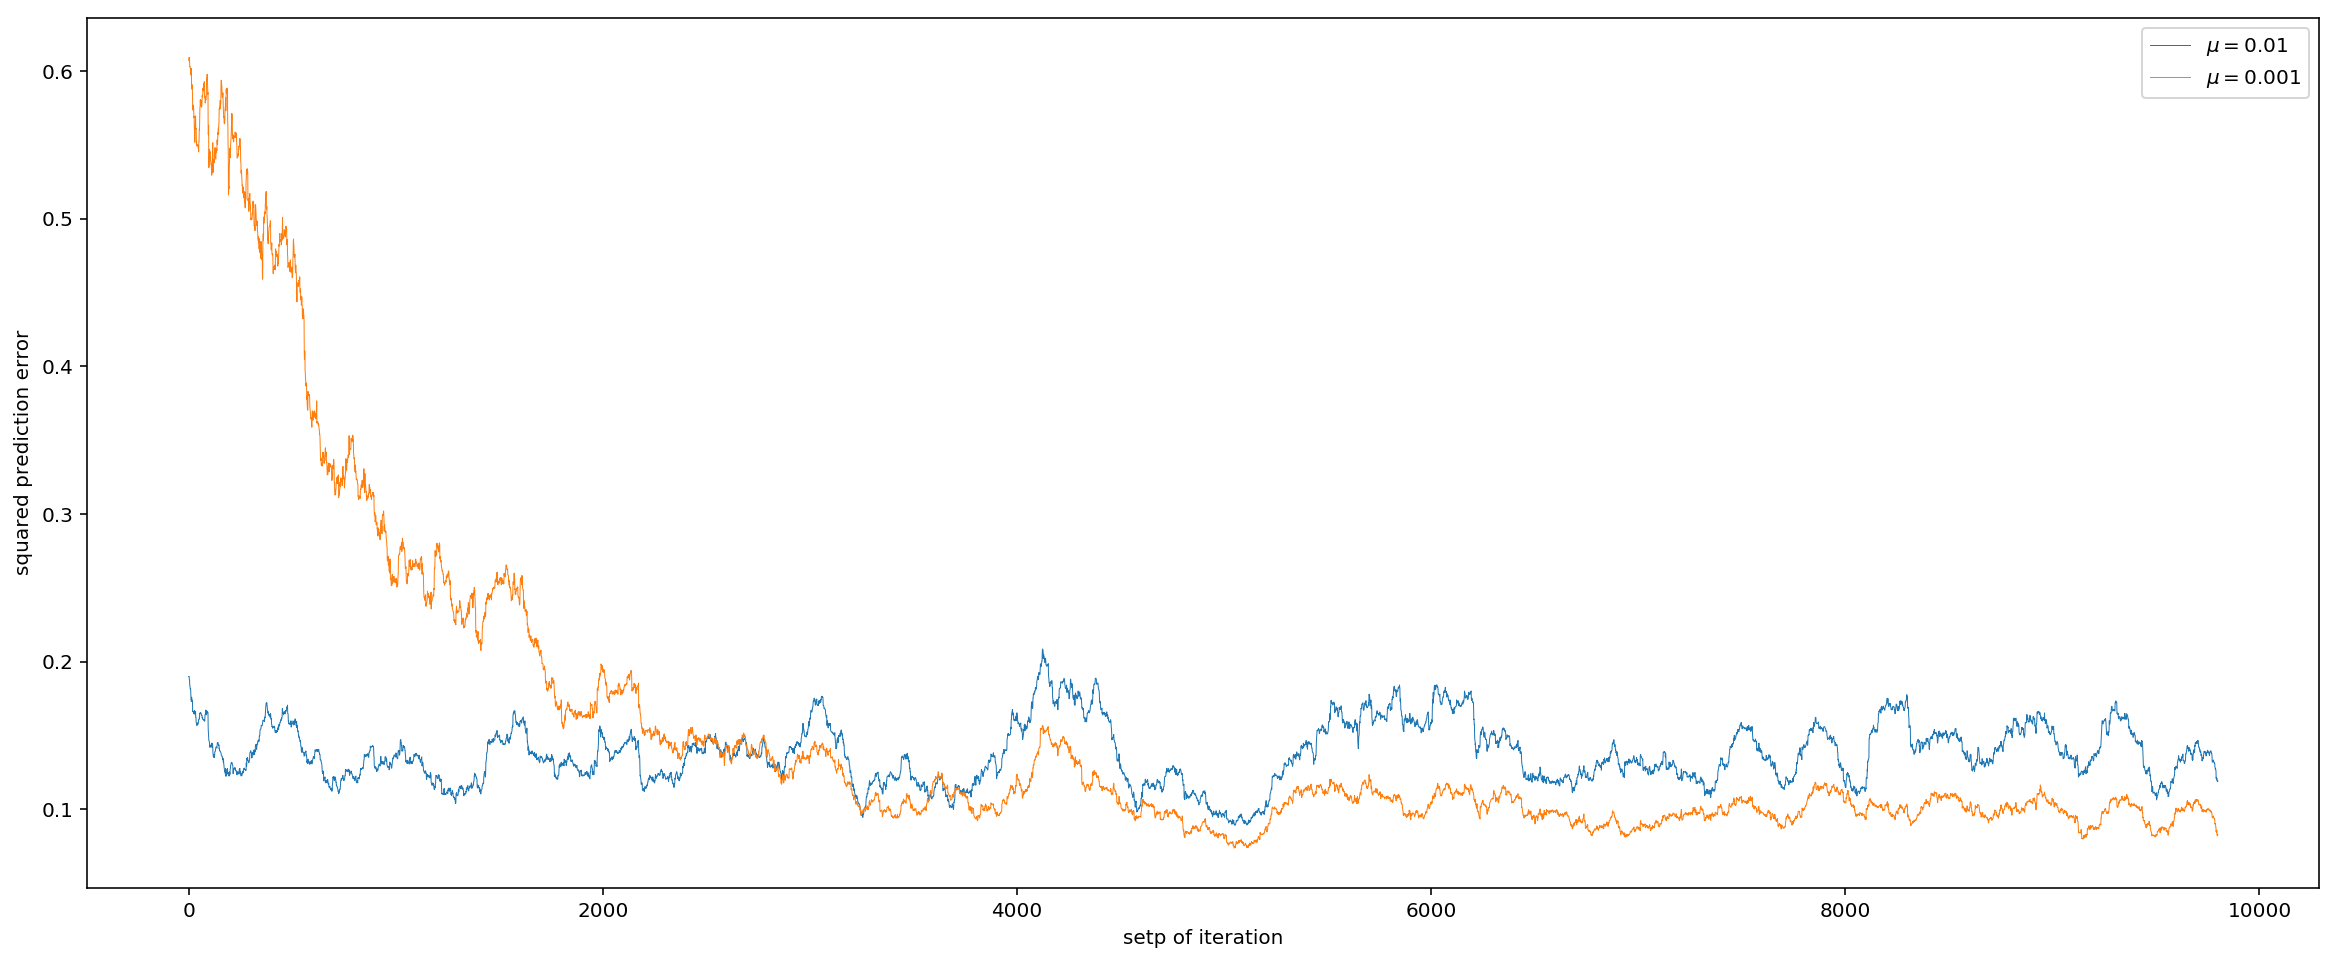

In [16]:
plot(lms(5,DfirN01,Xfir,0.1)[1],'$\mu=0.01$');
plot(lms(5,DfirN01,Xfir,0.0005)[1],'$\mu=0.001$');

a slower learning rate has the benefit of a smaller misadjugment when convergence is achieved

# IIR system identification

## given IIR filter

![structure of iir](AF2018/IIRstructure.png)

![weights of iir](AF2018/IIRweights.png)

## New heading

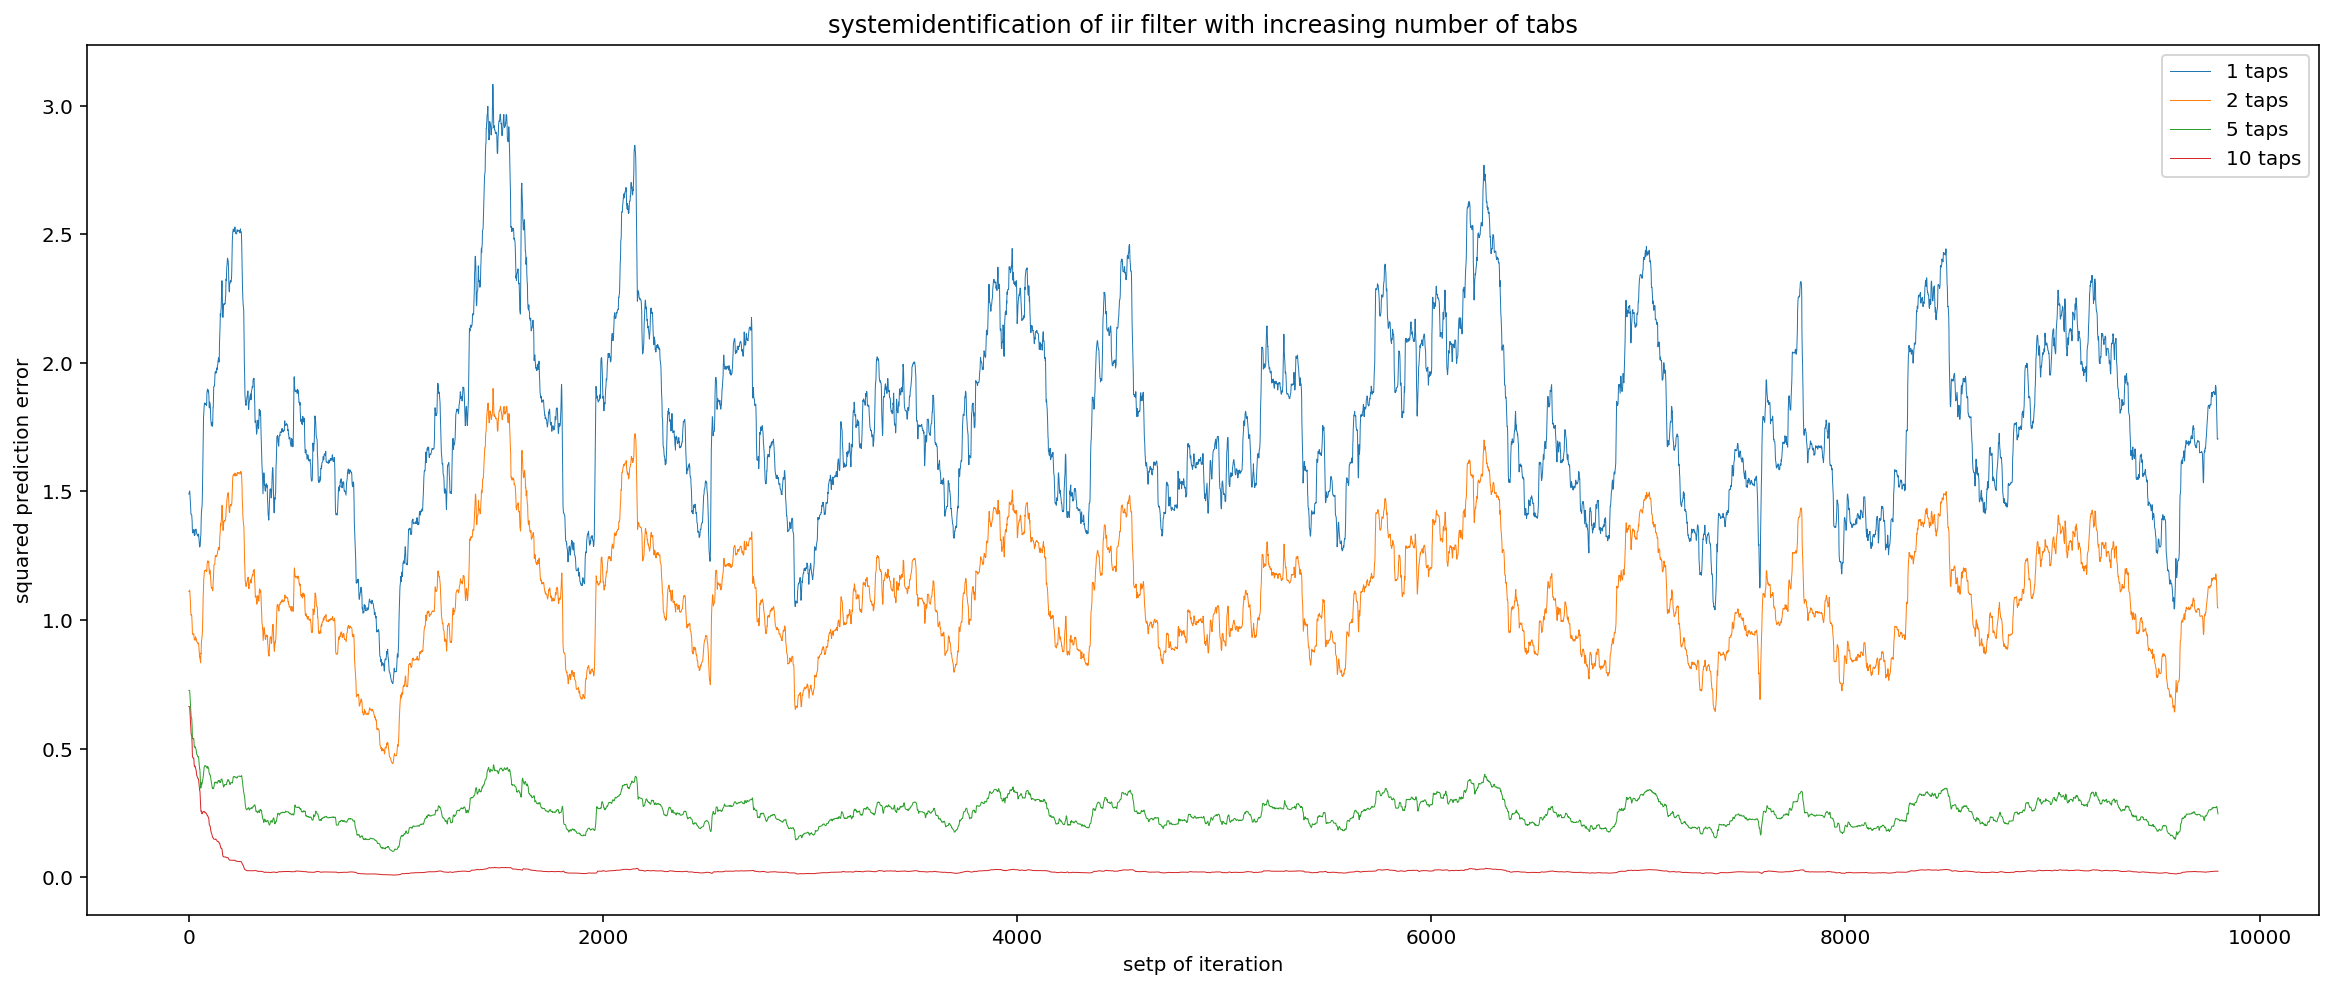

In [18]:
[plot(lms(taps,Diir,Xiir)[1],str(taps)+' taps') for taps in [1,2,5,10]];
plt.title('systemidentification of iir filter with increasing number of tabs');

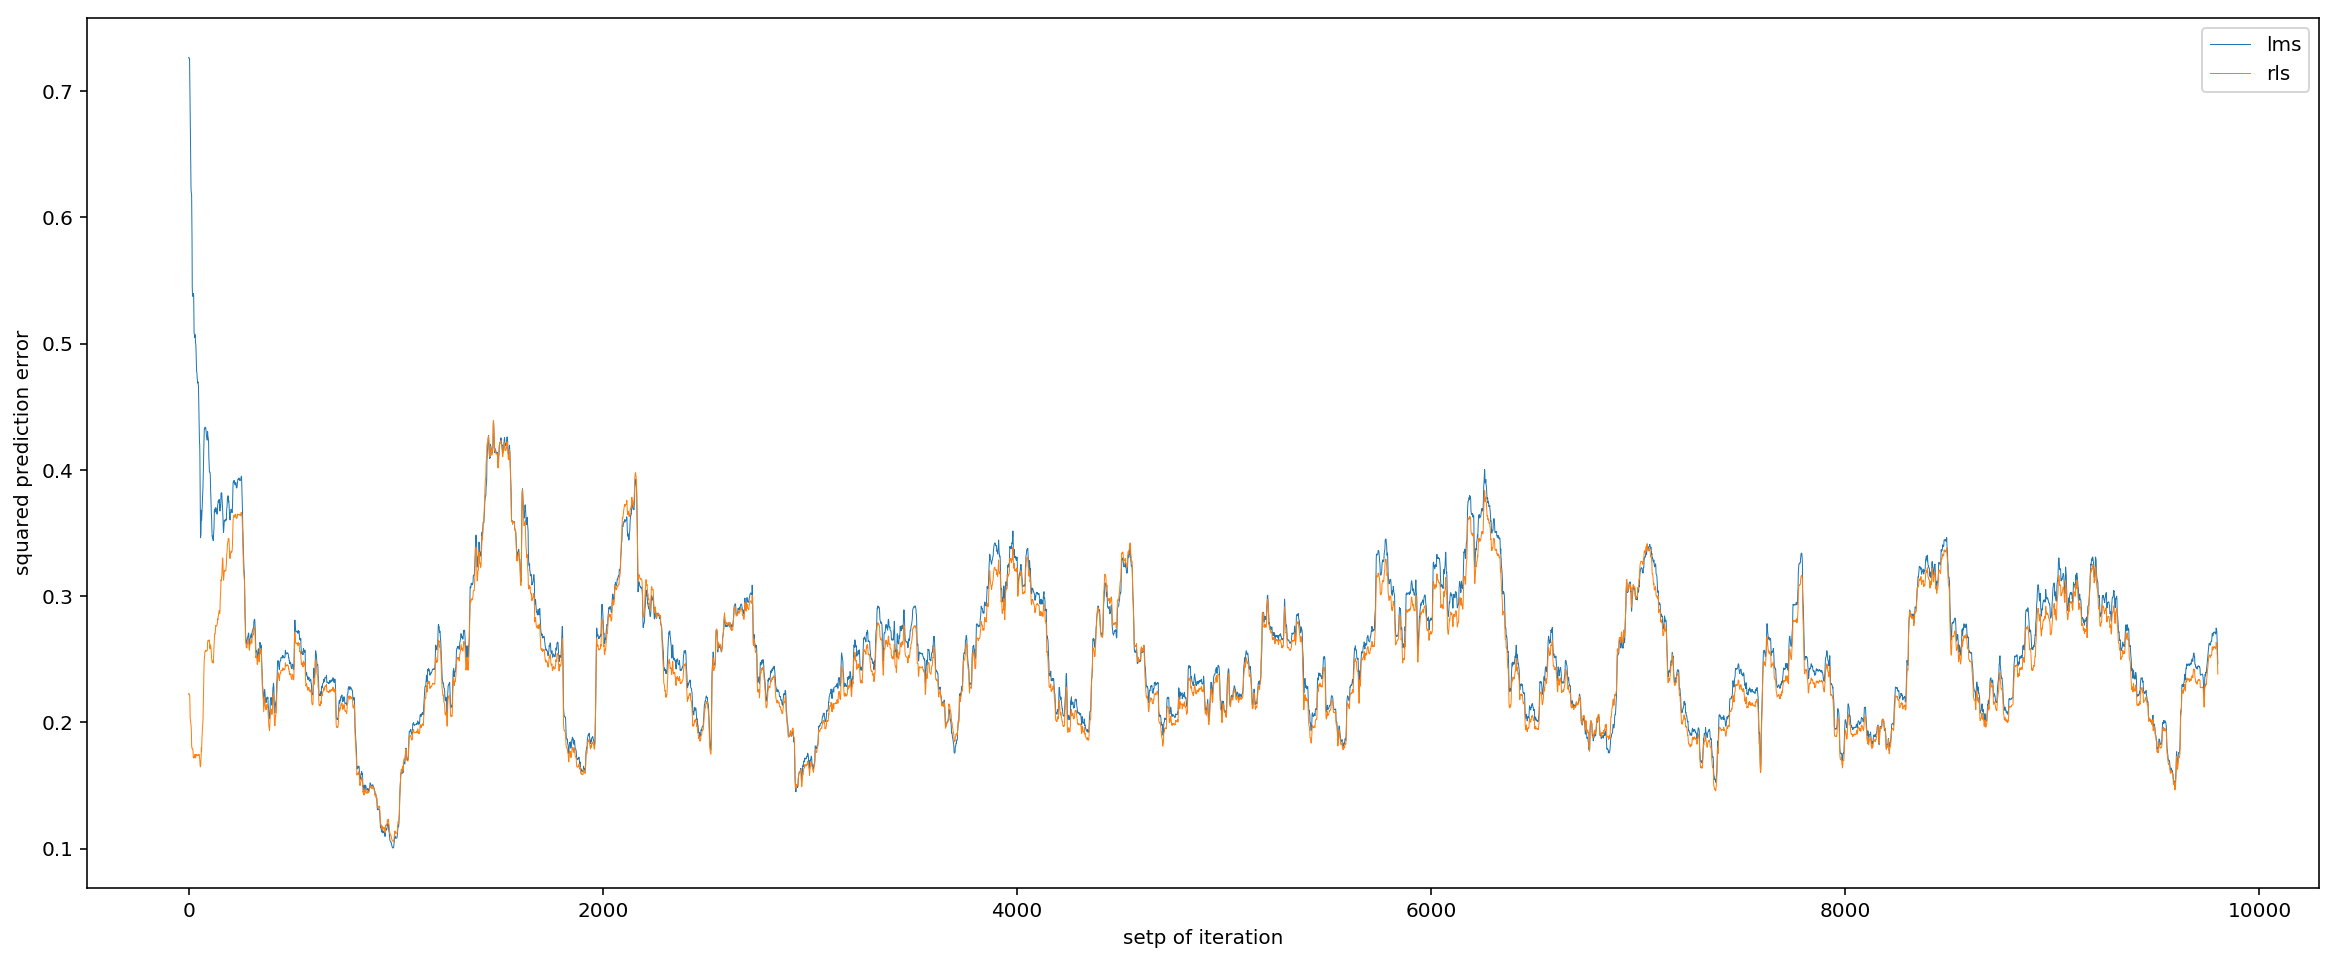

In [19]:
plot(lms(5,Diir,Xiir)[1],'lms'); plot(rls(5,Diir,Xiir)[1],'rls');

### Systemwechsel

In [17]:
# IIR system with taps:
Hiir = np.array([0.82, -0.03])

Diir_hat = sig.lfilter(tuple([1,0]),tuple(Hiir),tuple(Xiir))
print('are the Signals identical?')
np.allclose(Diir,Diir_hat)

are the Signals identical?


False

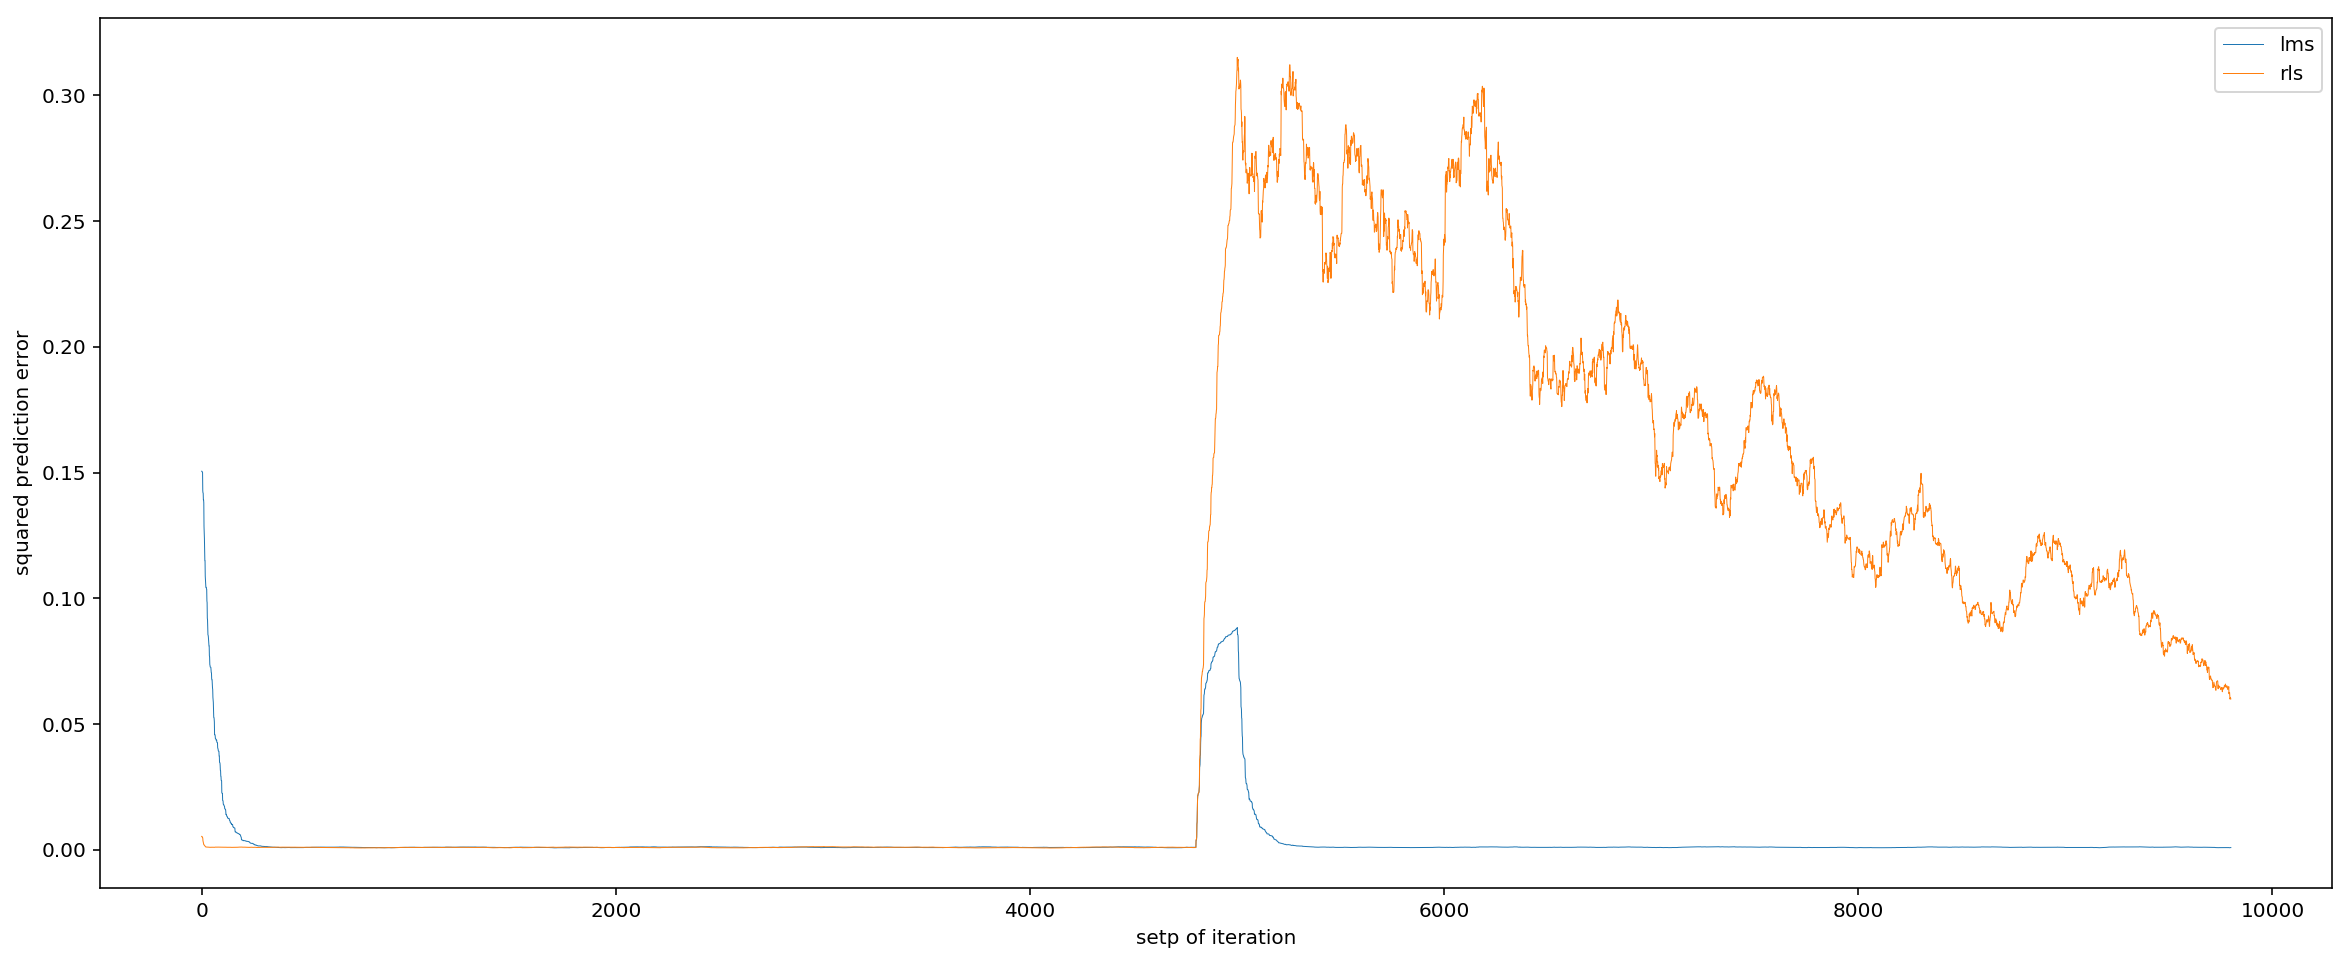

In [20]:
plot(lms(5,addnoise(Dfirx,0.001),Xfirx)[1],'lms')
plot(rls(5,addnoise(Dfirx,0.001),Xfirx)[1],'rls')

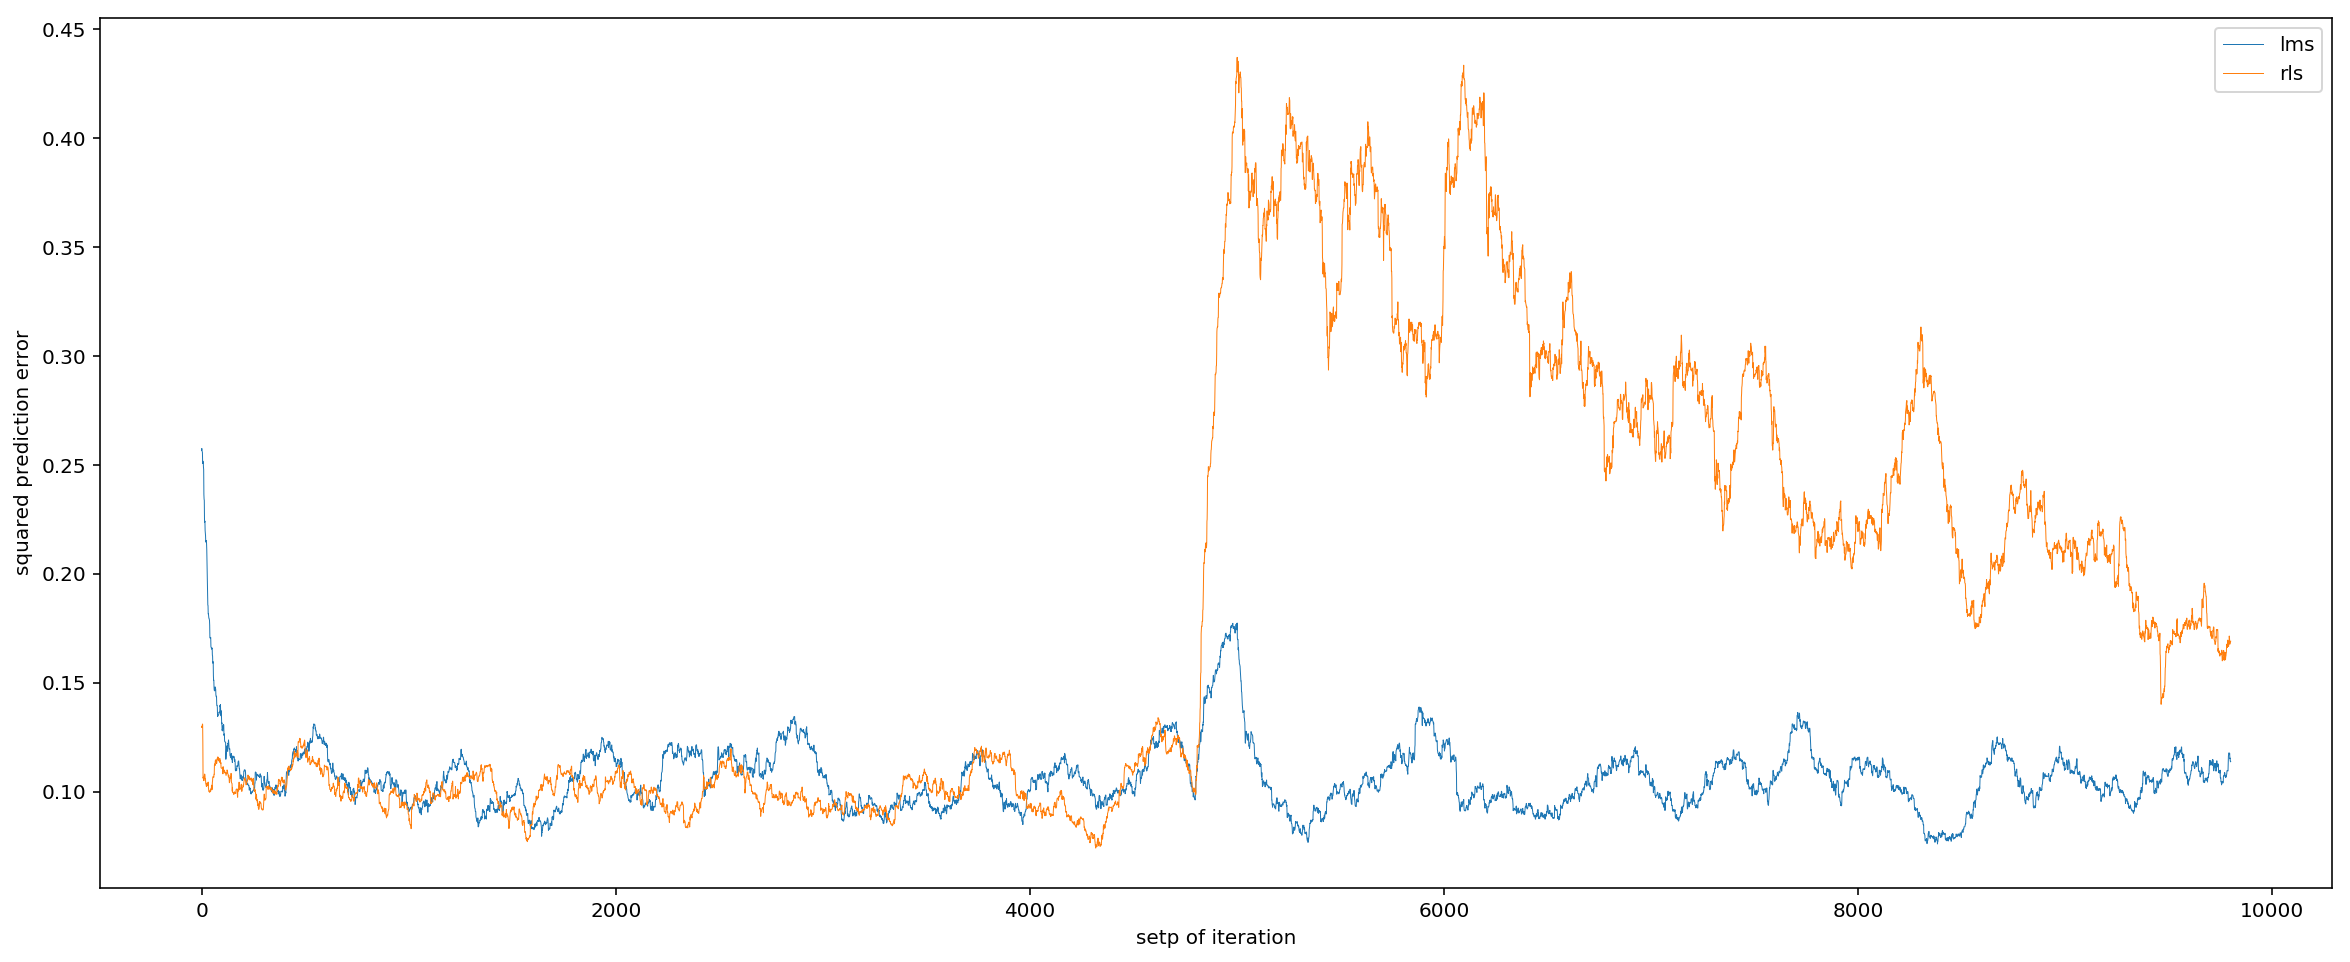

In [21]:
plot(lms(5,addnoise(Dfirx,0.1),Xfirx)[1],'lms')
plot(rls(5,addnoise(Dfirx,0.1),Xfirx)[1],'rls')

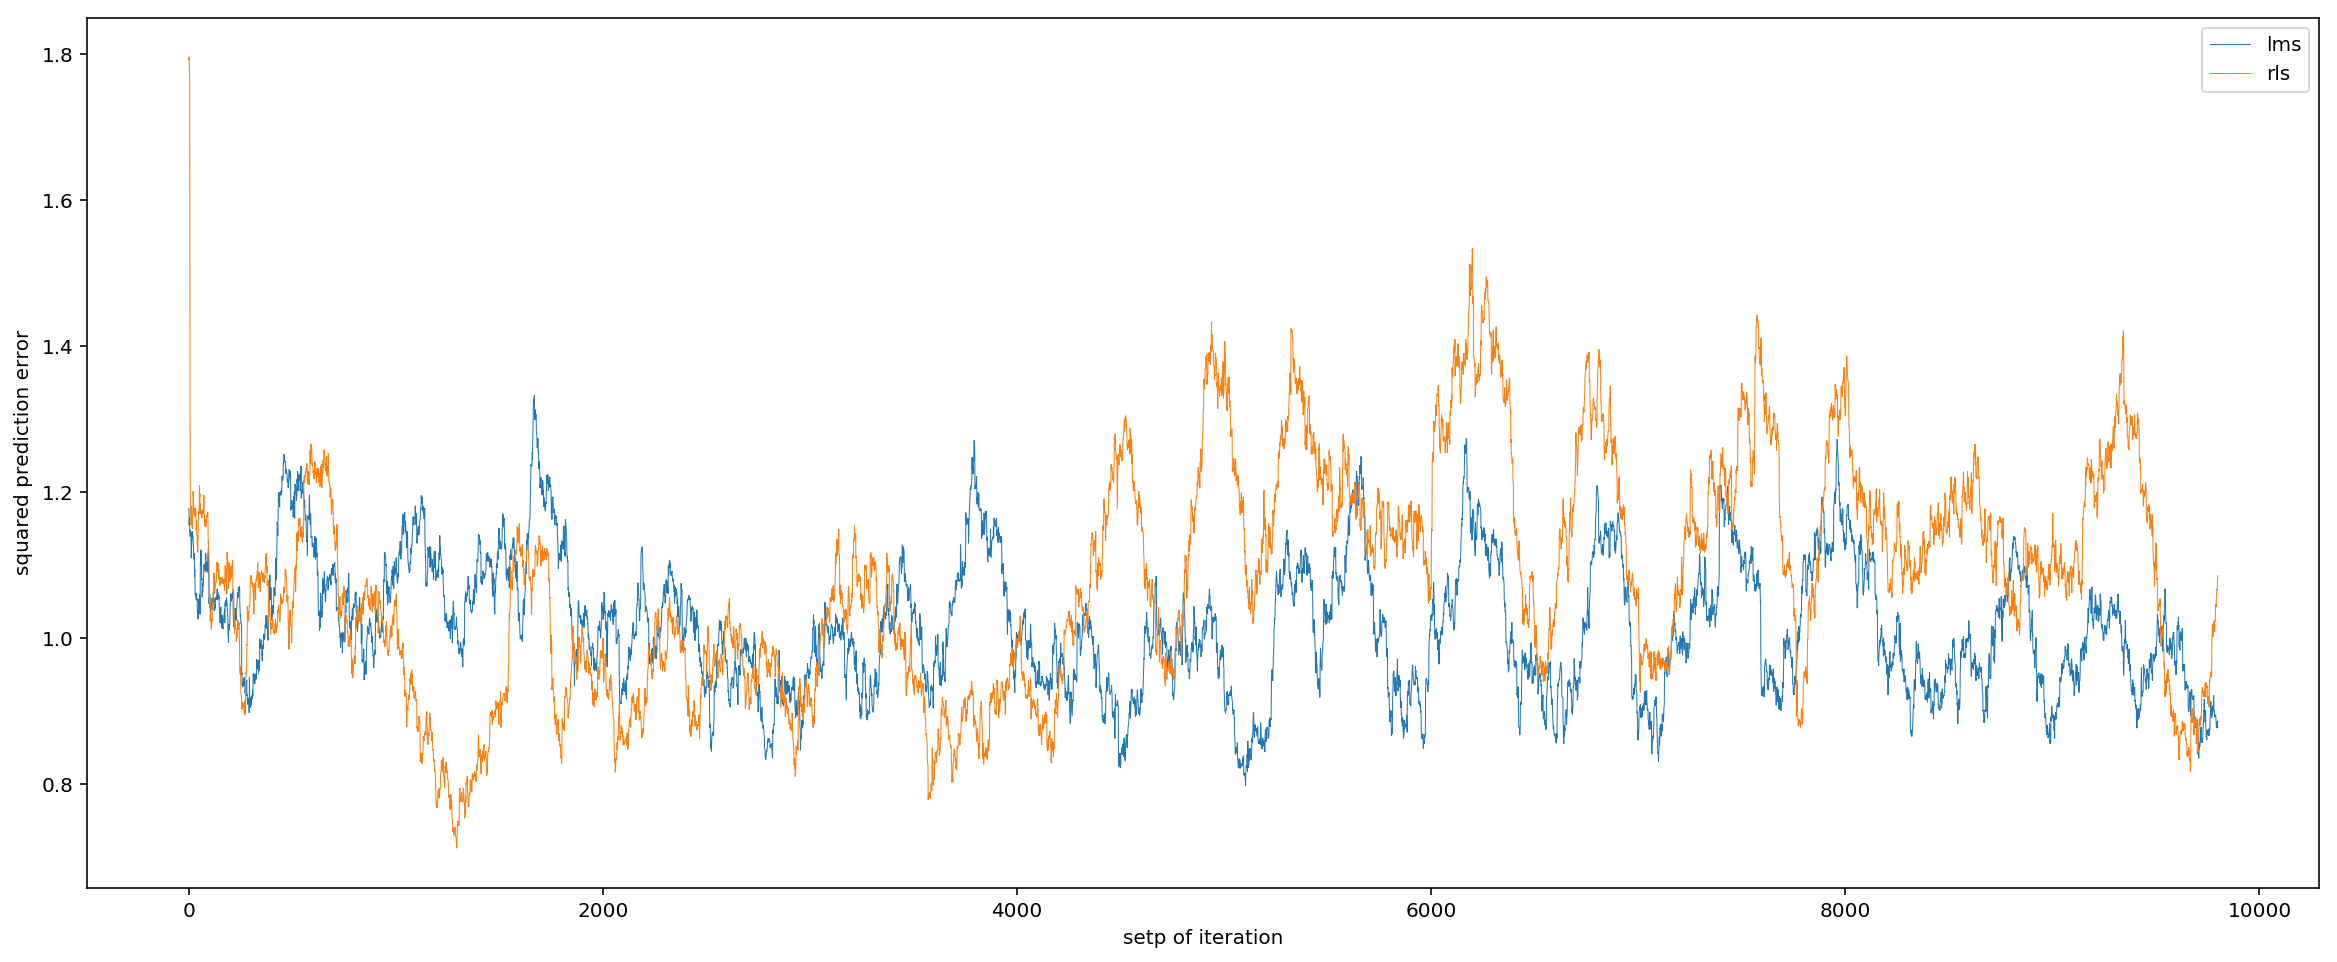

In [22]:
plot(lms(5,addnoise(Dfirx,1),Xfirx)[1],'lms')
plot(rls(5,addnoise(Dfirx,1),Xfirx)[1],'rls')

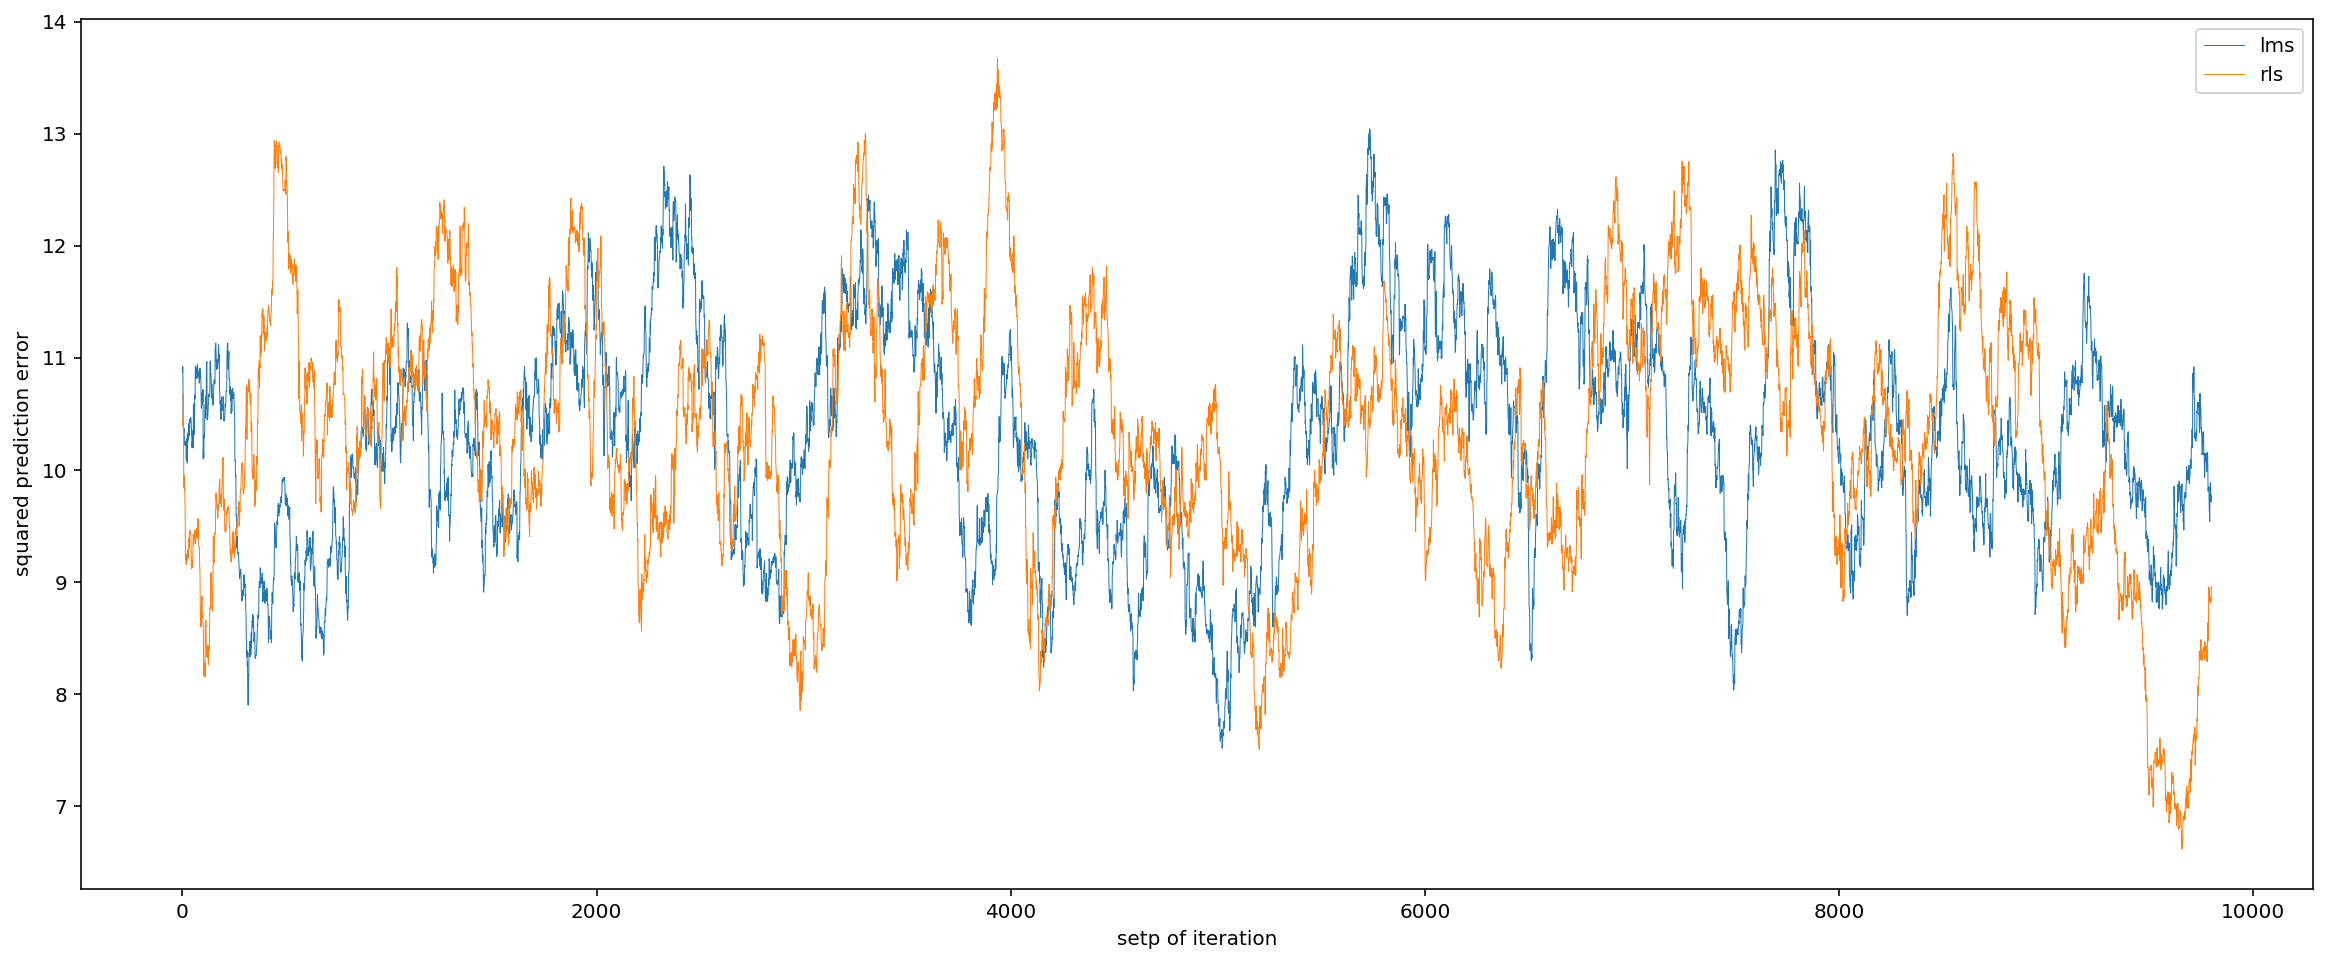

In [23]:
plot(lms(5,addnoise(Dfirx,10),Xfirx)[1],'lms')
plot(rls(5,addnoise(Dfirx,10),Xfirx)[1],'rls')

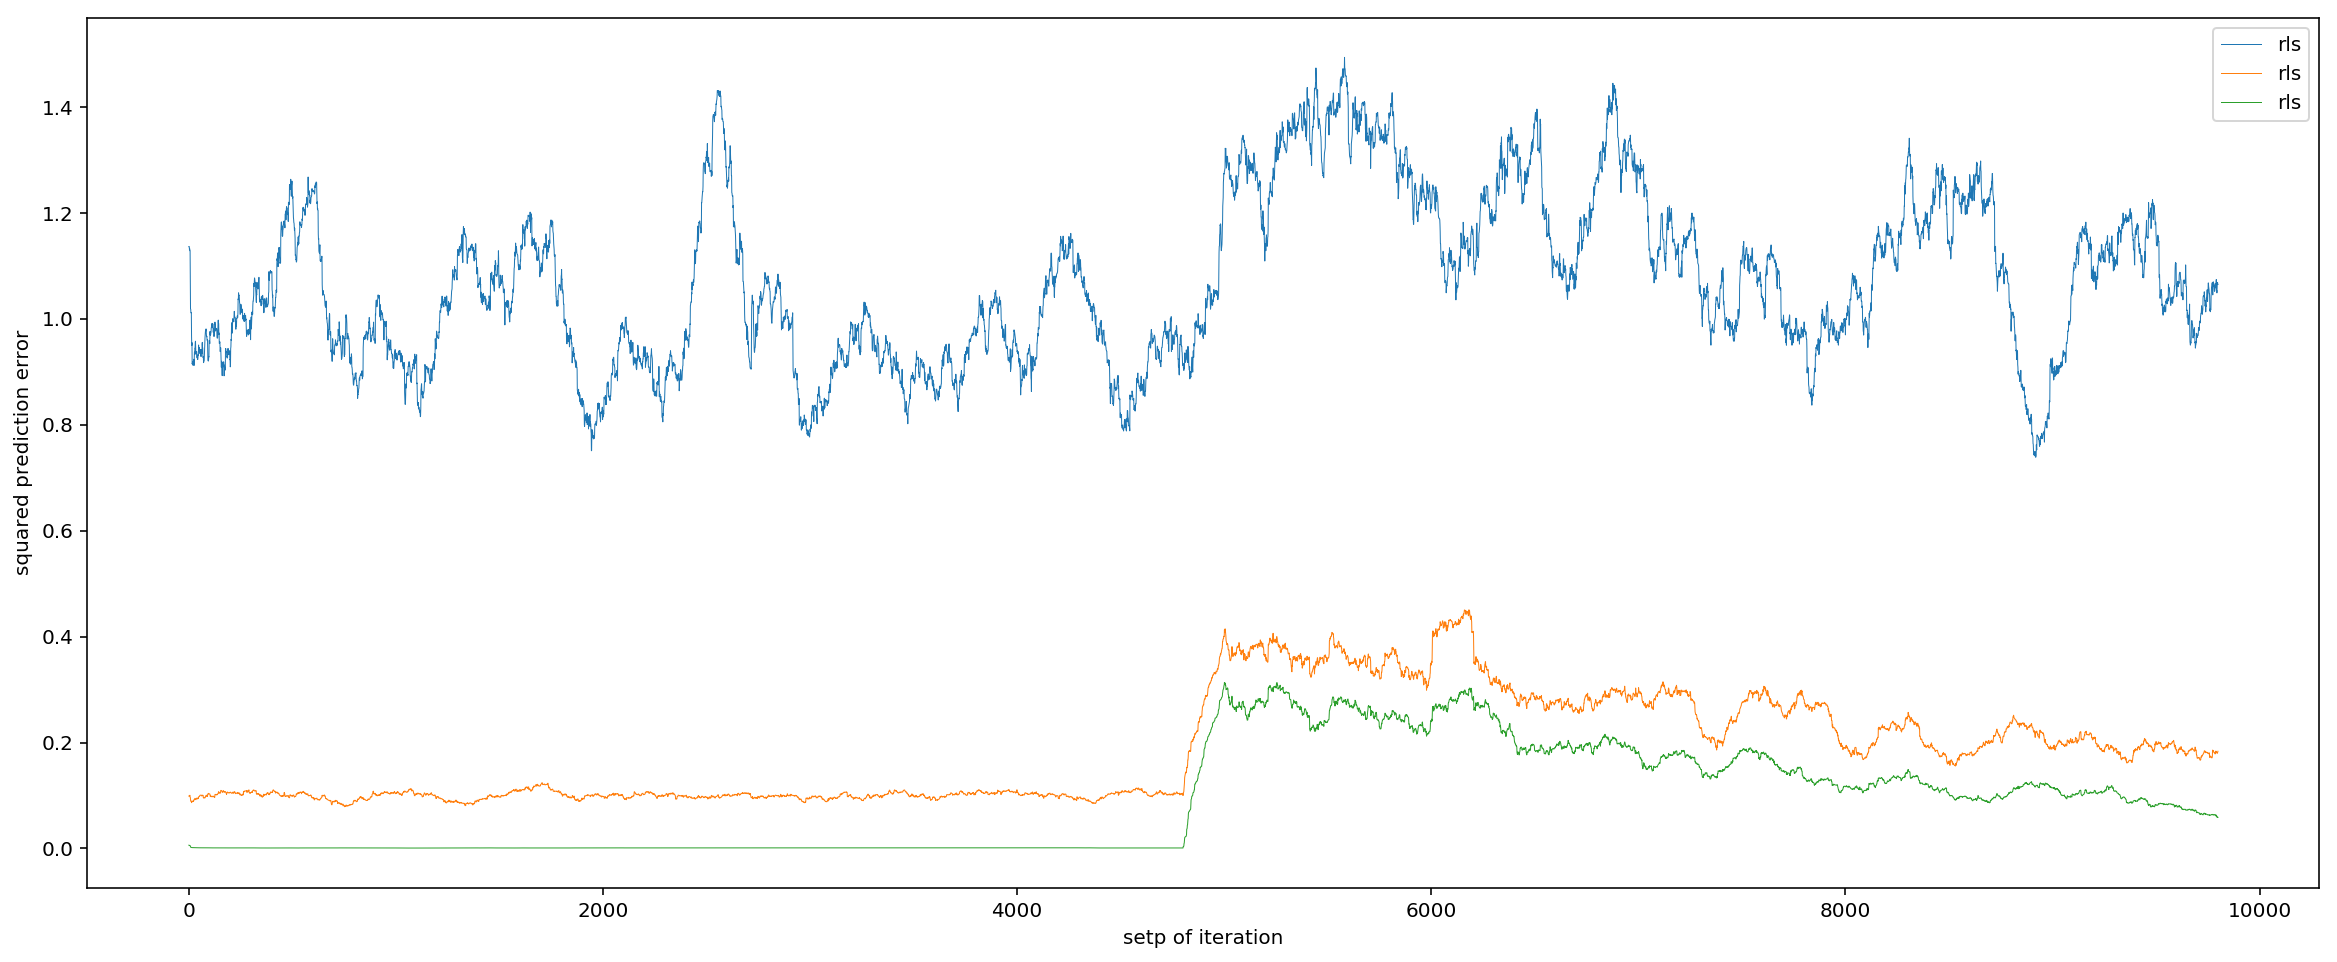

In [24]:
#plot(rls(5,addnoise(Dfirx,10),Xfirx)[1],'rls')
plot(rls(5,addnoise(Dfirx,1),Xfirx)[1],'rls')
plot(rls(5,addnoise(Dfirx,0.1),Xfirx)[1],'rls')
plot(rls(5,addnoise(Dfirx,0.001),Xfirx)[1],'rls')

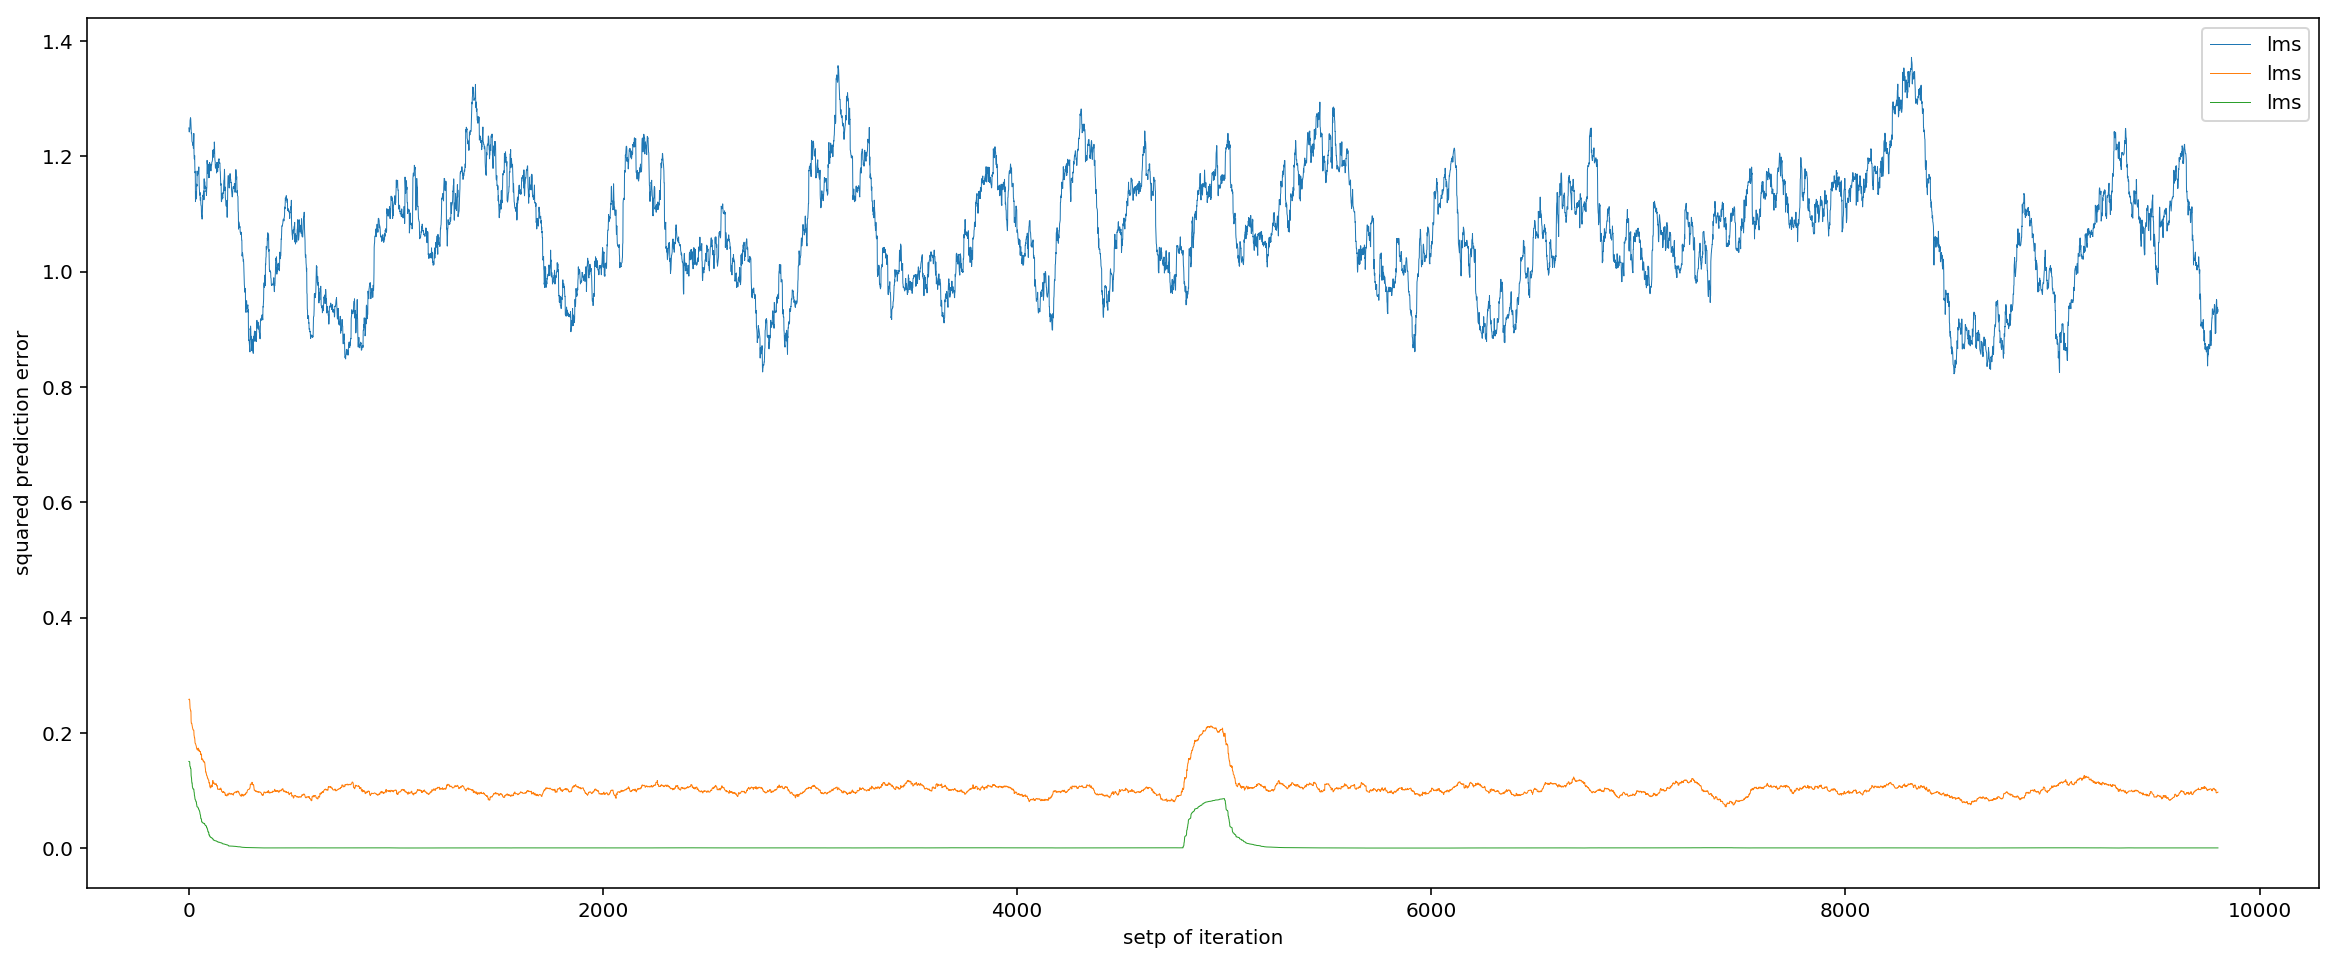

In [25]:
plot(lms(5,addnoise(Dfirx,1),Xfirx)[1],'lms')
plot(lms(5,addnoise(Dfirx,0.1),Xfirx)[1],'lms')
plot(lms(5,addnoise(Dfirx,0.001),Xfirx)[1],'lms')

### New heading

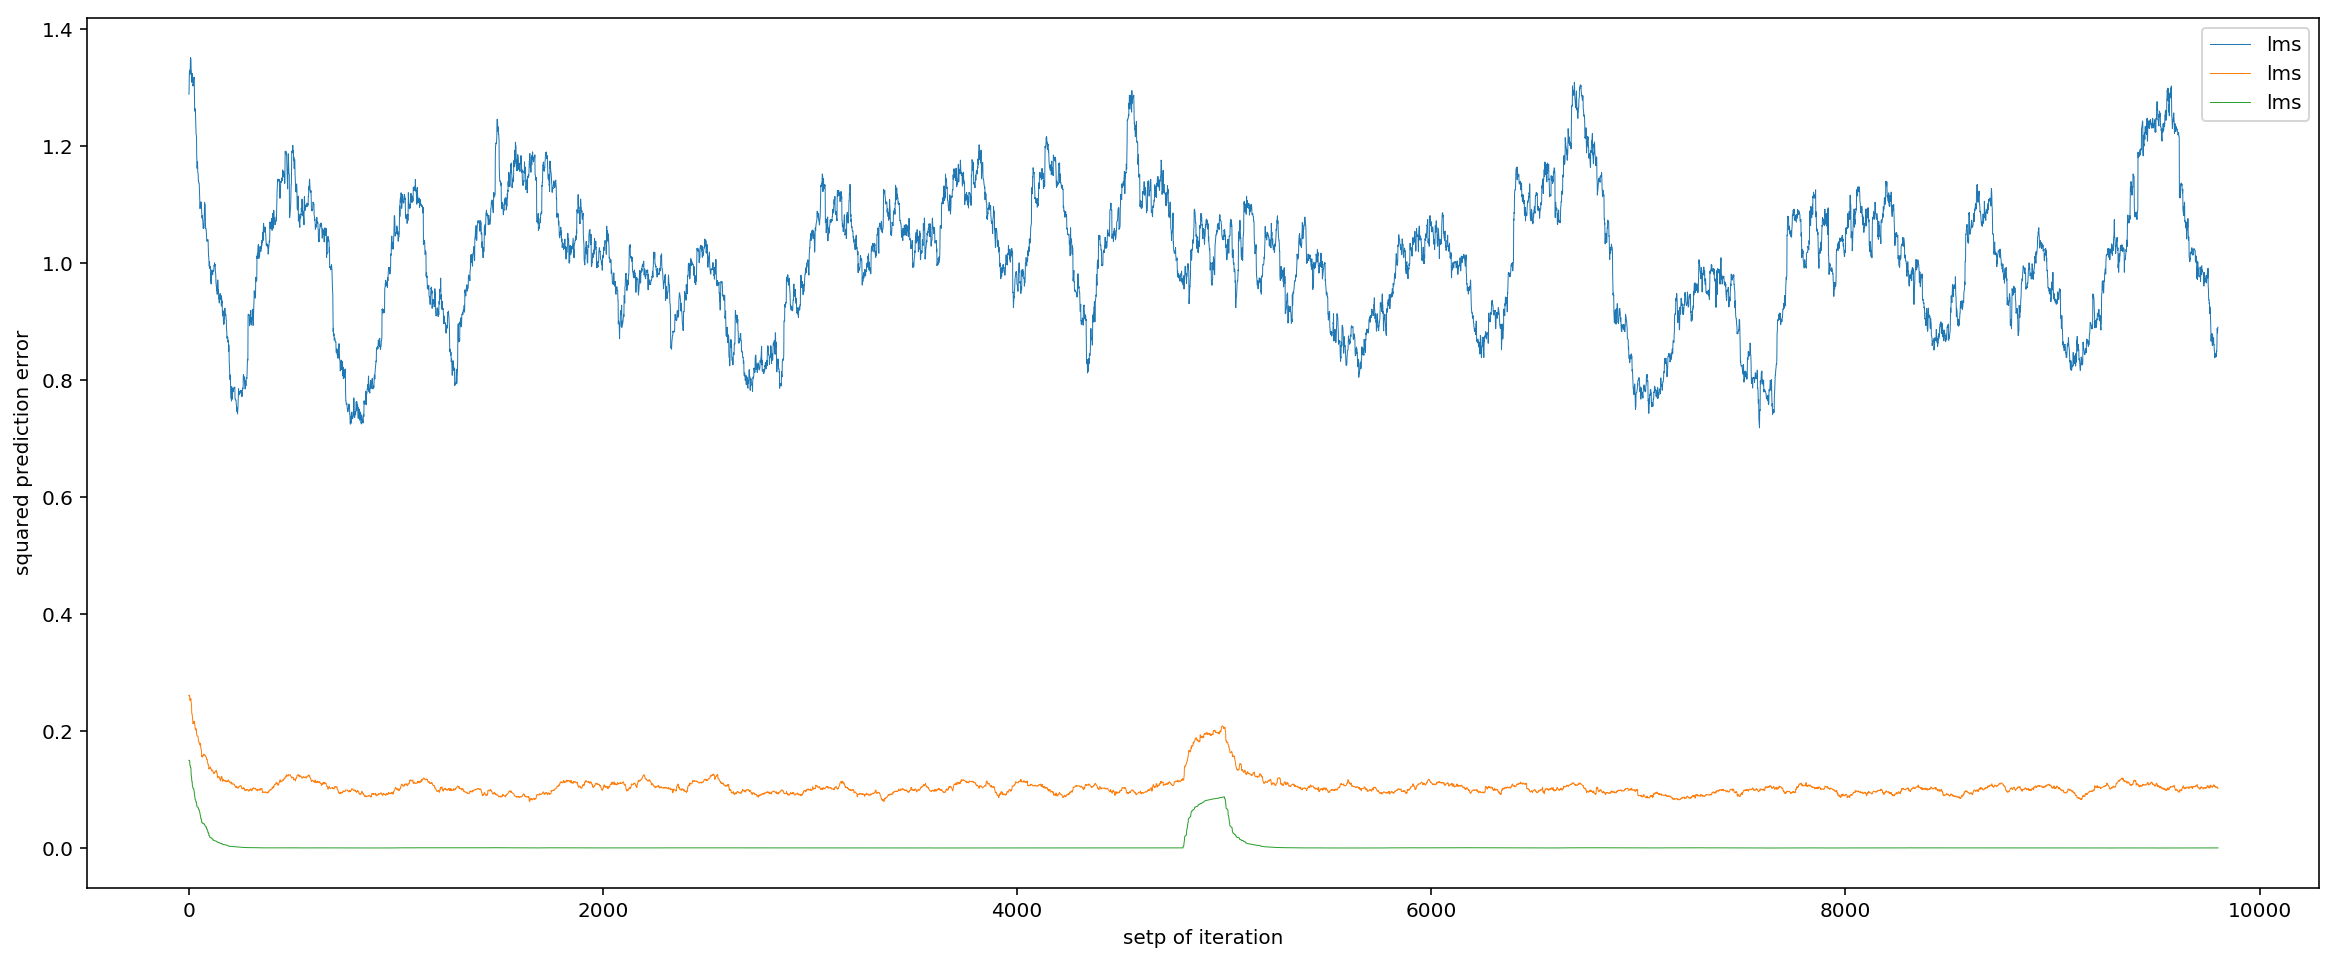

In [26]:
for noise in [1,0.1,0.001]:
    plot(lms(5,addnoise(Dfirx,noise),Xfirx)[1],'lms')

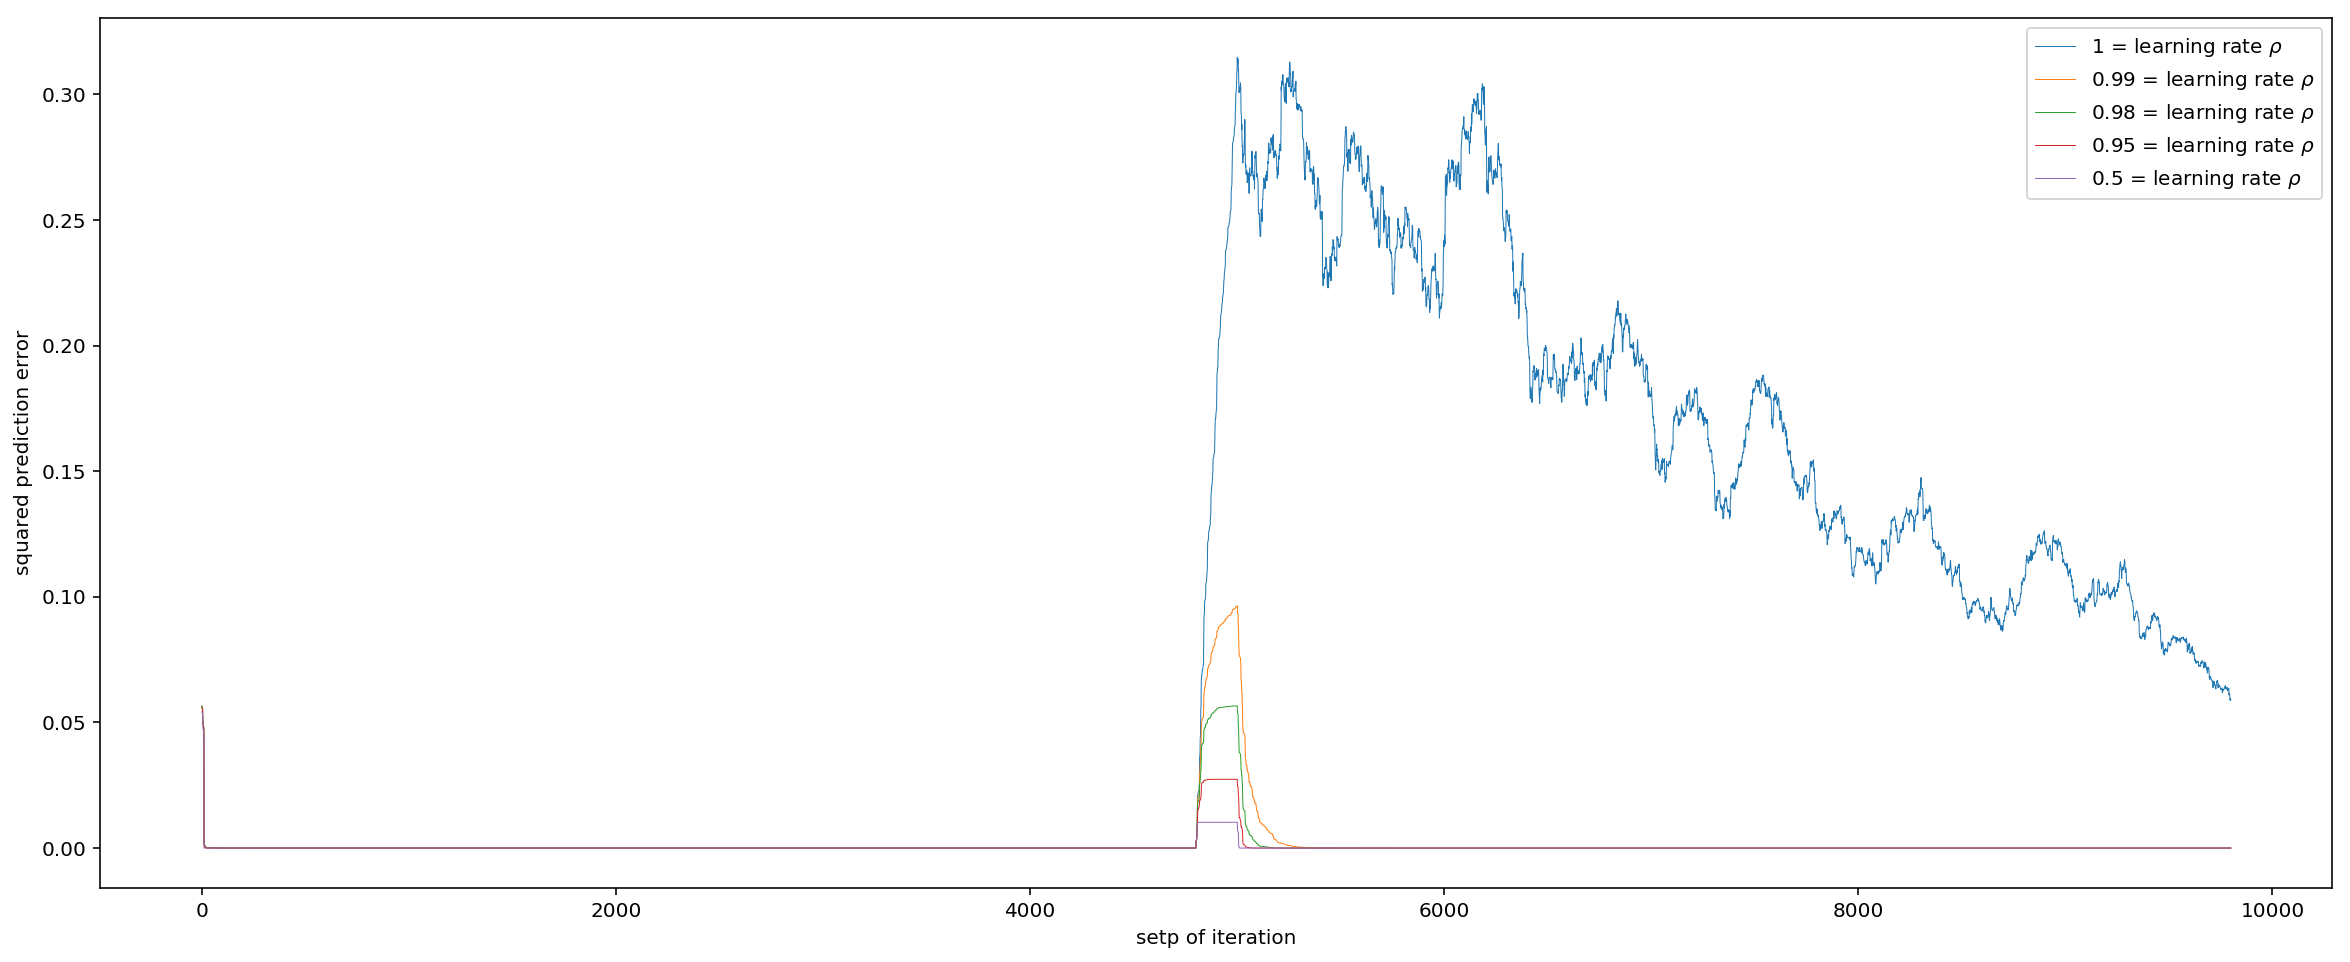

In [27]:
for rate in [1,0.99,0.98,0.95,0.5]:
    error = rls(10,Dfirx,Xfirx,rate)[1]
    plot(error,str(rate)+' = learning rate $\\rho$')
    plt.legend()

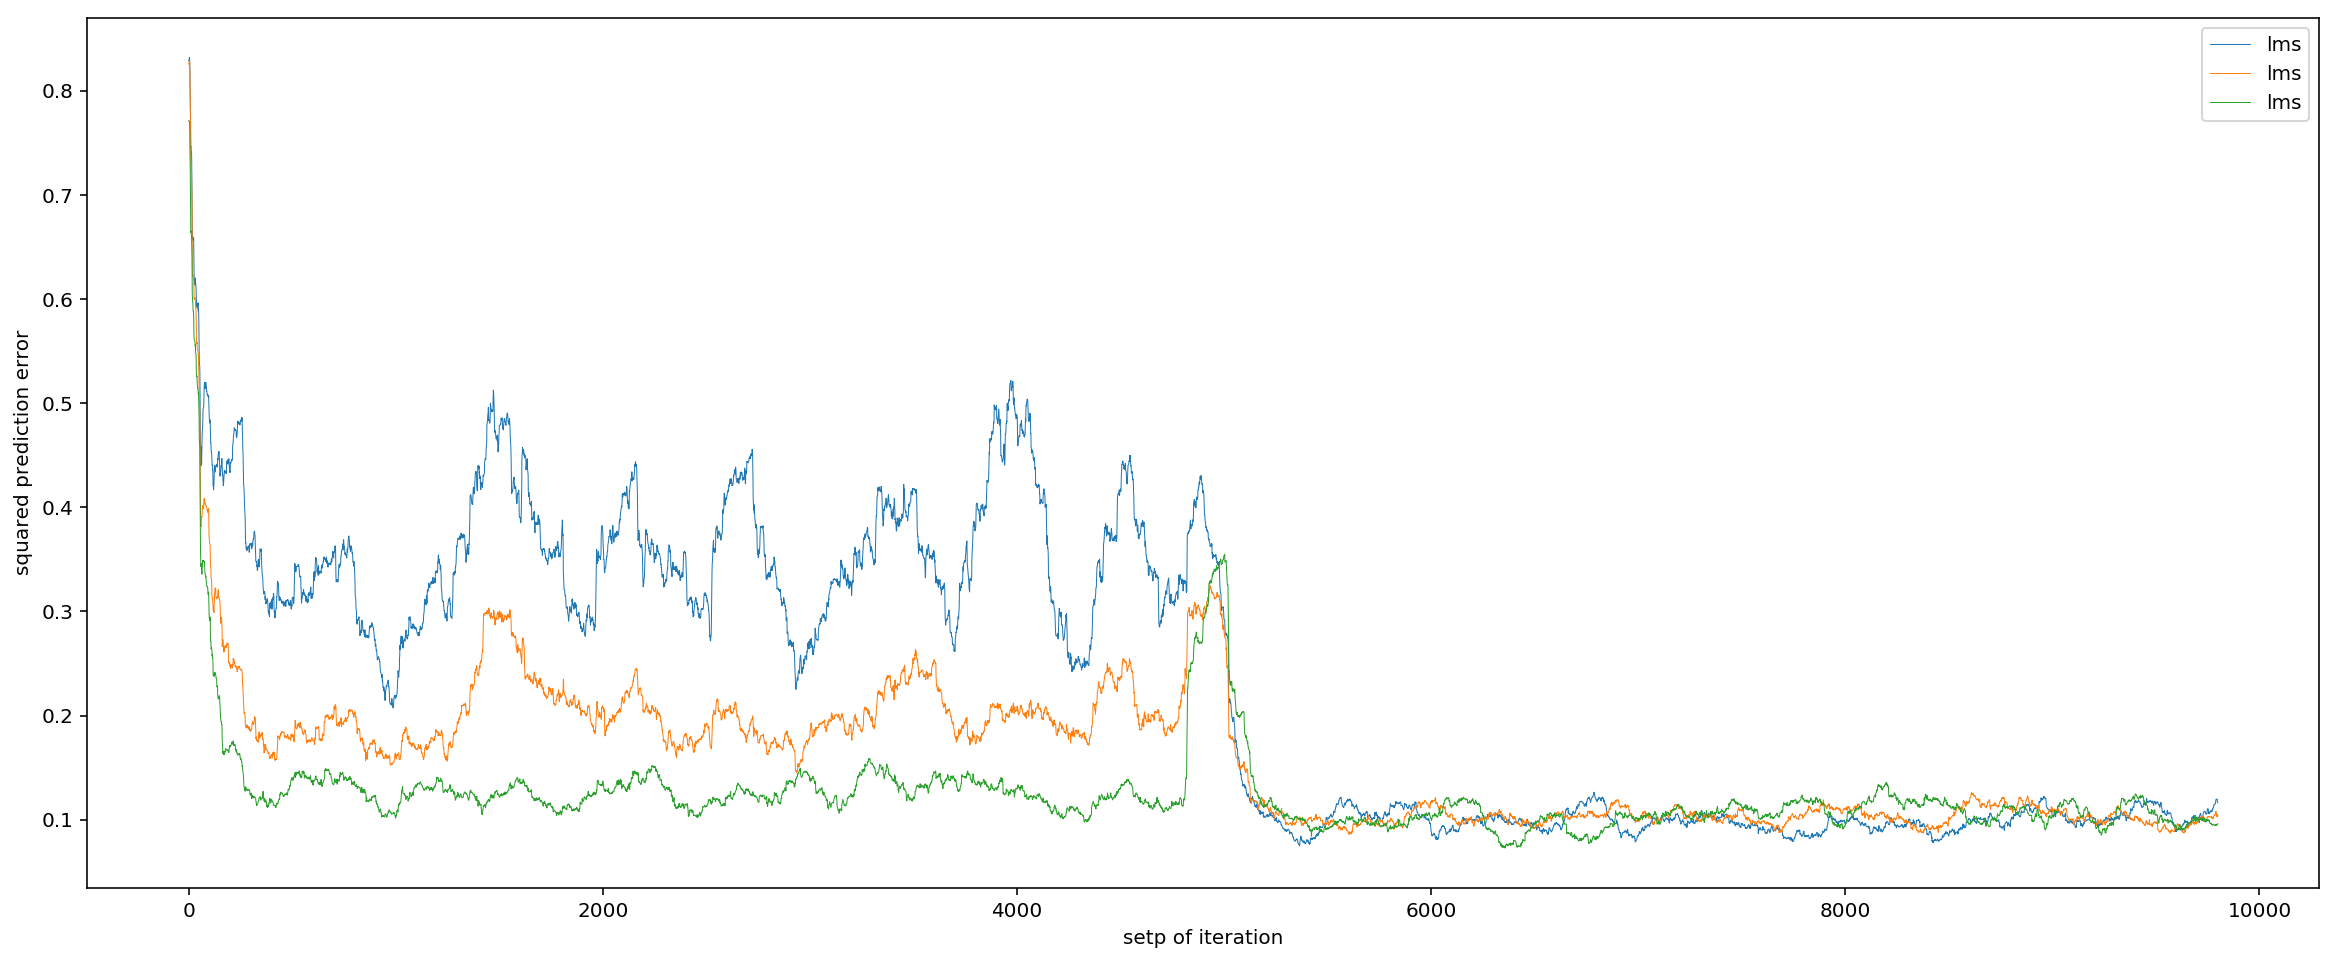

In [28]:
for N in [5,7,10]:
    plot(lms(N,addnoise(Diirx,0.1),Xiirx,0.01)[1],'lms')

notes from moschiytz lms:
* Beim LMS die Lösung der Wienergleichung mit Hilfe eines approximierten Gradienten bestimmt.
* Dabei muss der Überschussfehler $J(w\underline)$.
* Ist einfach zu implementieren.
* Hat aber eine langsame Konvergenz bei schlecht konditioniertem Eingangssignal.


notes from moschytz rls:
* Aufstartphase: Daten nach Initialisierung haben stärkeren Einfluss.
* Später hinzugefügte Werte haben geringeres Gewicht.
* Regiert zu Beginn sehr sehr schnell, nach N bis 2N ist Transient abgeklungen.
* Nachführphase: dominante zeitliche Mittelung. 
* Selbst bei hoher Vergessenrate wird er nicht so schnell sein wie zu Beginn.
* Konditionierung ist egal, weil self orthongonalizing, s.h S.150
* Fehleninstellung hängt vom Vergessensfaktor ab, wenig vergessen gute Fehl.


# Kernel Lest Mean Squares

Kernel is $K(\mathbf{u},\mathbf{u}') = e^{(-a \lVert{u-u'\lVert}^2)}$

In [21]:
class KLMS:
    def __init__(self, num_params, learningstep = 0.5, sigma = 0.5):
        self.old_ins = [np.zeros(num_params)]
        self.weights = [0]
        self.learningstep = learningstep
        self.sigma = sigma
        self.error = None
        self.prediction = [0] 
        self.errors = [0]
        
    def kernel(self,x,y):
        dist_len = (x-y)@(x-y)
        bysig = dist_len / (2 * self.sigma ** 2)
        kern = np.exp(-bysig)
        return kern
    
    def predict(self,new_in):
        estimate = 0
        for i in range(len(self.weights)):
            estimate_i = self.weights[i] * self.kernel(self.old_ins[i],new_in)
            estimate += estimate_i
        return estimate
    
    def update(self, new_in, expected):
        #import pdb; pdb.set_trace()
        self.error = expected - self.predict(new_in)
        new_weight = self.learningstep * self.error
        self.weights.append(new_weight)
        self.old_ins.append(new_in)
        self.prediction.append(self.predict(new_in))
        self.errors.append(self.error**2)

In [22]:
train = sio.loadmat('AF2018/Training.mat')['x_training'][:,0]
test = sio.loadmat('AF2018/Test.mat')['x_test'][:,0]

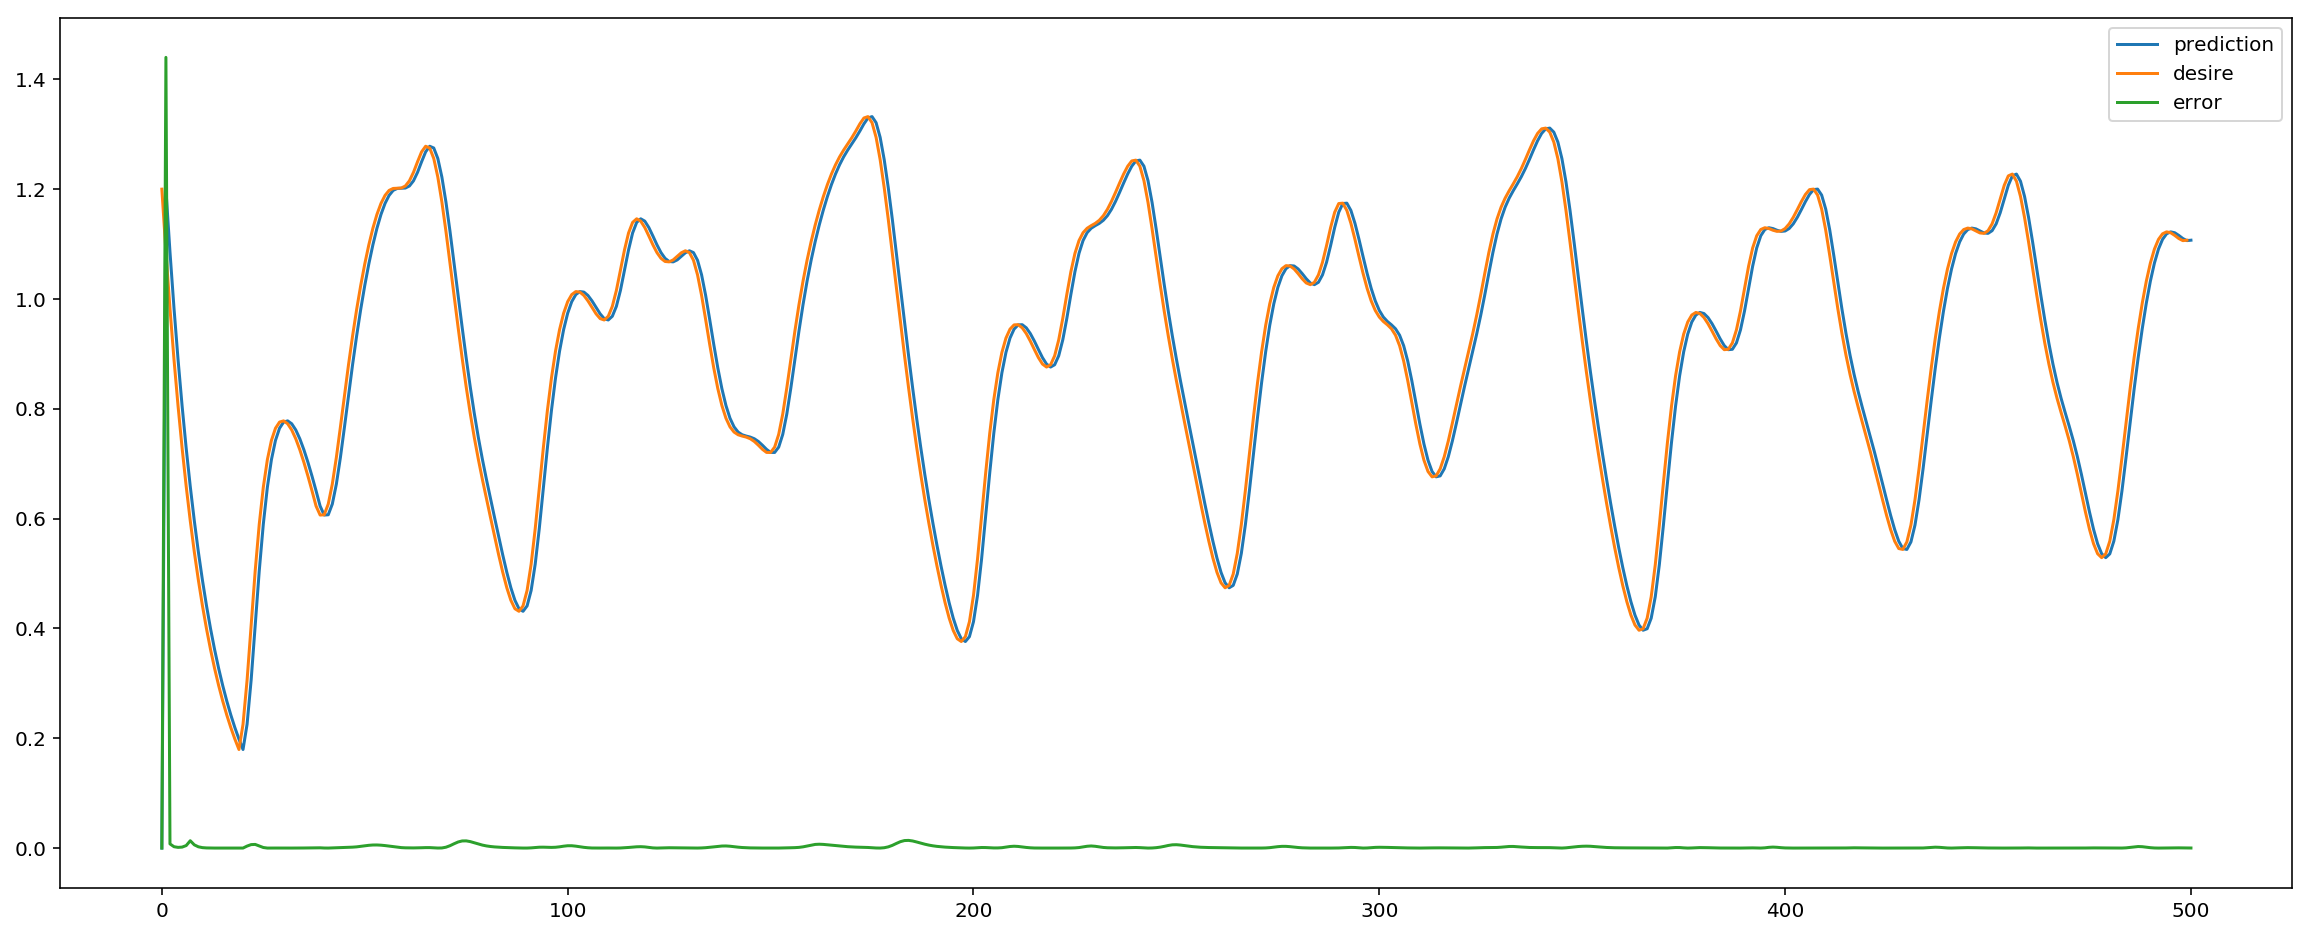

In [23]:
N = 5
changemat = toeplitz(train)[:N+1,:]
X = changemat[1:N+1,:]
d = changemat[0,:]
kernelfil = KLMS(N,learningstep=1,sigma=1)

err = []
for i in range(0,len(d)):
    kernelfil.update(X[:,i],d[i])
plt.plot(kernelfil.prediction,label='prediction')
plt.plot(d,label='desire')
plt.plot(kernelfil.errors,label='error')
#plt.plot(kernelfil.weights,label='weights')
plt.legend();

In [17]:
plt.plot(y[:500])
plt.plot(d[:500])
plt.plot((y[:500]-d[:500])**2)

NameError: name 'y' is not defined

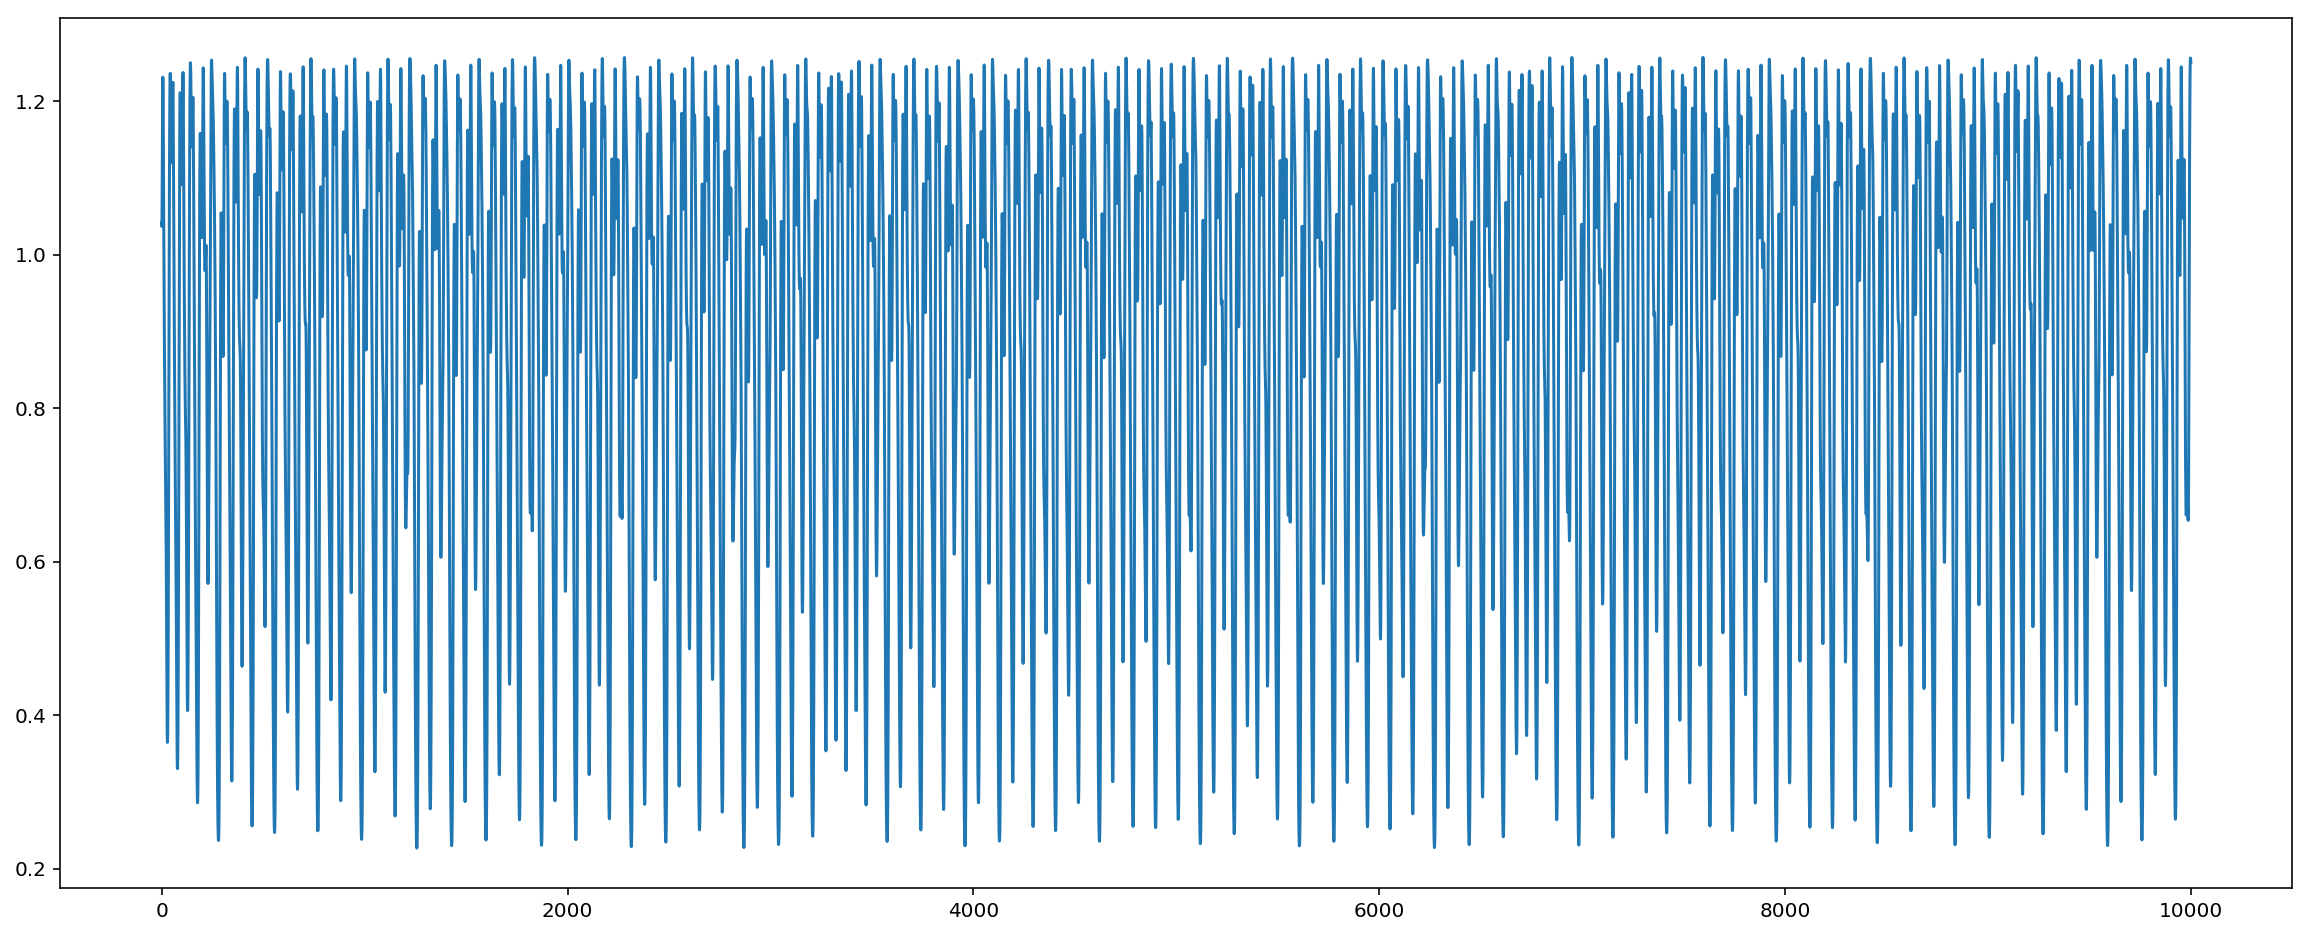

In [113]:
changemat = toeplitz(test)[:N+1,:]
X = changemat[1:N+1,:]
d = changemat[0,:]
estimate = []
for i in range(0,len(d)):
    estimate.append(kernelfil.predict(X[:,i]))
plt.plot(estimate)

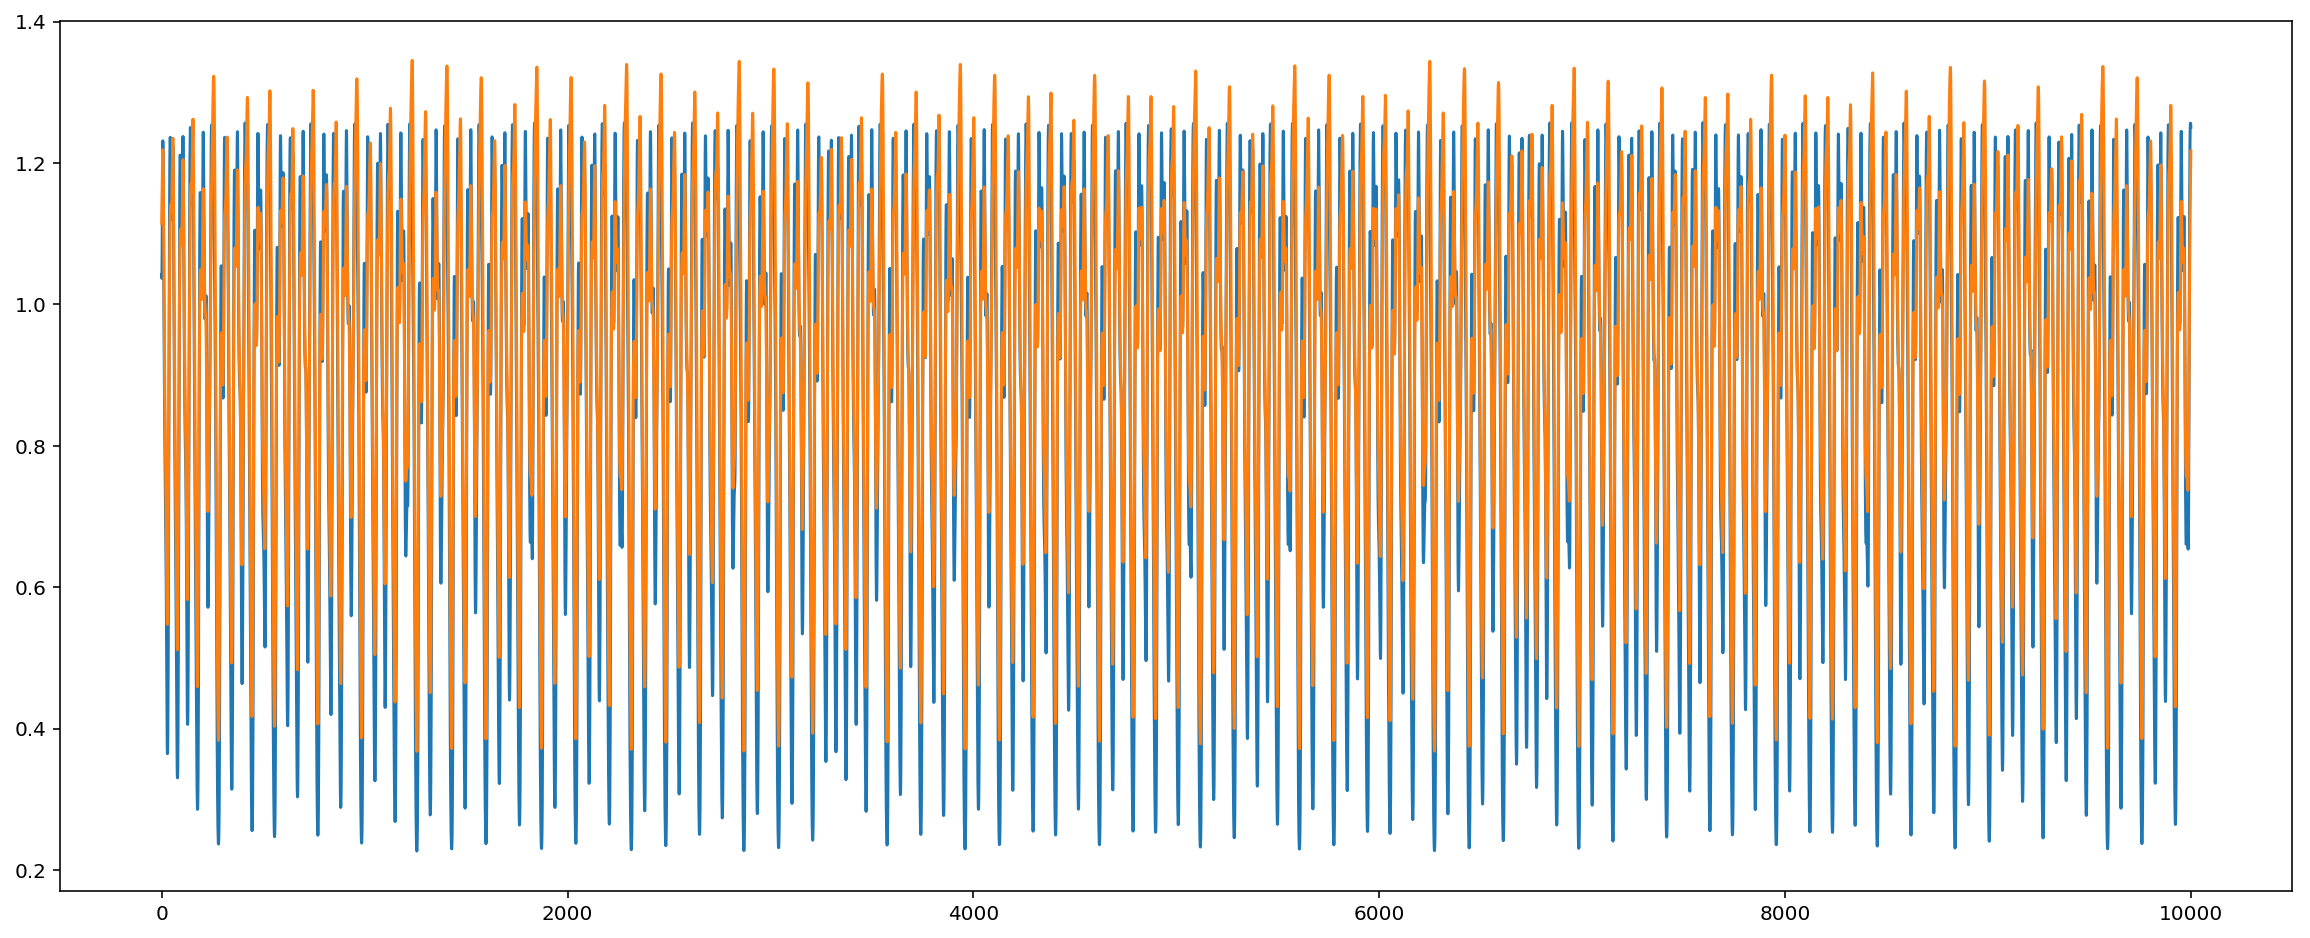

In [114]:
plt.plot(estimate)
plt.plot(d)